# <u> Data Bootcamp Final Project <u>

## Data Analysis of NBA Statistics

### Topics Covered:
* #### Historical Trends
* #### Relationships Between Statistics/Correlation with Win Shares
* #### A look into Undervalued, Underplayed, and Strong Performing Players
* #### Valuation Model and Evaluating Players
    
### Summary:

The purpose of this project is to analyze different NBA statistics to better understand players' values. We downloaded our data from Kaggle at the links below, which were originally extracted from ESPN. This data came out very raw, and we filtred our data for 2017, eliminatind duplicates due to trades and salary changes and using the most updated version of each player. We also deleted two empty columns to allow ourselves to more readily manipulate the data. Additionally, we filtered for different positions, minutes, and salaries to look even more closely at the numbers and better compare players.

Before conducting our player analysis, we were curious to see how the NBA has changed over time. We decided to examine how points per season has changed with respect to time and increase of 3-point shots attempted. People tend to believe there is more "isolation" plays now than before, when a player attempts to take on his defender one-on-one, so to assess the validity of this claim we took the 97th percentile Usage Rating for each year and observed how it changed. Contrarily, we saw that the usage rates are actually about the same, suggesting this hypothesis was incorrect.

Next, we examined how different key statistics correlate to win shares. We used this stat because we believe that at the end of the day, a player's value is determined by how he influences his team and delivers them wins. However, players on the same team or with fewer minutes played will inherantly have a lower value of win shares, so we therefore used the correlation coefficients of the key statistics to determine the values of players, using the numbers to weigh the importance of each stat since win shares alone can be biased.

Throughout the project, we adjusted our dataframes to only include players who played an average of at least 2 minutes per game, as we saw players who played minimal minutes sometimes saw extremely high usage rates and efficiency ratings if they happened to accumulate stats during these minutes. We believe that this increased the reliability of our results by eliminating those numbers which were skewed. In analyzing player performances, we took into account the minutes played and salaries earned by each player to find the players who may be undervalued or deserve more minutes.

Finally, we created a valuation model for evaluating players, using our correlation coefficients of the key statistics vs. win shares. We multiplied each statistic by their coefficient and divided it by the number of stats we used in order to get our own version of the wins they bring their team using the average of multiple statistics. This method proved to be effective, as the top players were the all-stars, with the highest valued player also being named Most Valuable Player (MVP) of the NBA for both 2016 and 2017. After looking at the top 20 valued players, we examined the top players at each position and at a low salary mark for each position as well. We believe our findings would be useful for an NBA GM in deciding which players to target and carrying out different transactions.


#### Team: *James Haag* and *David Chou*

#### Sources:
    https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv
    https://www.kaggle.com/whitefero/nba-player-salary-19902017#Player%20-%20Salaries%20per%20Year%20(1990%20-%202017).xlsx. 

In [1]:
%matplotlib inline 
import pandas as pd
pd.set_option('display.max_columns', 60)
import matplotlib.pyplot as plt
import datetime as dt
import os
import requests, io
import zipfile as zf
import shutil
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression as reg
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.neighbors import KNeighborsRegressor as knn
plt.style.use('seaborn')

In [2]:
stats = pd.read_csv('Seasons_Stats.csv')
stats = stats.drop(columns = ['blanl','blank2','Unnamed: 0'])

In [3]:
salary = pd.read_excel("nbaSals.xlsx", sheetname = 'Player Salaries')
salary['Year'] = salary['Season End'] # adjust for differences in reporting of year
salary.drop(['Register Value', 'Season Start', 
                'Season End', 'Full Team Name'], axis=1, inplace=True) # drop unneeded columns
salary.columns = ['Player', 'Salary', 'Tm', 'Year'] # rename columns to match for eventual merge
salary17 = salary.loc[salary['Year'] == 2017]
# gathering the 2017 salary data for use in valuing different players

//anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [4]:
stats17 = stats.loc[stats['Year'] == 2017]
salary17['Year'] = salary17['Year'].astype(float)
# We first had to change salary17's years to float values to merge the two datasets
stats17 = stats17.merge(salary17[['Player','Salary']],on='Player',how='inner')
stats17 = stats17.drop_duplicates(subset = 'Player', keep = 'first')
# Players who were traded or signed a new salary were counted multiple times. This accounts for that and uses their
# most recent values

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
stats82gms = stats.loc[stats['Year'] > 1967]
#We will use this dataframe to accurately compare pt spreads over years, as there were now 82 games per year
stats3p = stats.loc[stats['Year'] > 1979]
#It was not until after 1979 when the 3 point line was introduced in the NBA. 
#This will be used in our regression to find the relationship between 3 pointers attempted and points scored
statsUSG = stats.loc[stats['Year'] > 1977]
#When the usage percentages started being recorded
statsBPM = stats.loc[stats['Year'] > 1974]
#When the Box Plus Minus began being recorded
statsPG = stats.loc[stats['Pos'] == 'PG']
stats17PG = stats17.loc[stats17['Pos'] == 'PG']
statsSG = stats.loc[stats['Pos'] == 'SG']
stats17SG = stats17.loc[stats17['Pos'] == 'SG']
statsSF = stats.loc[stats['Pos'] == 'SF']
stats17SF = stats17.loc[stats17['Pos'] == 'SF']
statsPF = stats.loc[stats['Pos'] == 'PF']
stats17PF = stats17.loc[stats17['Pos'] == 'PF']
statsC = stats.loc[stats['Pos'] == 'C']
stats17C = stats17.loc[stats17['Pos'] == 'C']
#created datasets for each positon, first including all years, then only including 2017
stats16 = stats.loc[stats['Year'] == 2016]

## Abbreviation Key:
    Year: Season
    Player: name
    Pos: Position
    Age: Age
    Tm: Team
    G: Games
    GS: Games Started
    MP: Minutes Played
    PER: Player Efficiency Rating
    TS%: True Shooting %
    3PAr: 3-Point Attempt Rate
    FTr: Free Throw Rate
    ORB%: Offensive Rebound Percentage
    DRB%: Defensive Rebound Percentage
    TRB%: Total Rebound Percentage
    AST%: Assist Percentage
    STL%: Steal Percentage
    BLK%: Block Percentage
    TOV%: Turnover Percentage
    USG%: Usage Percentage
    OWS: Offensive Win Shares
    DWS: Defensive Win Shares
    WS: Win Shares
    WS/48: Win Shares Per 48 Minutes
    OBPM: Offensive Box Plus/Minus
    DBPM: Defensive Box Plus/Minus
    BPM: Box Plus/Minus
    VORP: Value Over Replacement
    FG: Field Goals
    FGA: Field Goal Attempts
    FG%: Field Goal Percentage
    3P: 3-Point Field Goals
    3PA: 3-Point Field Goal Attempts
    3P%: 3-Point Field Goal Percentage
    2P: 2-Point Field Goals
    2PA: 2-Point Field Goal Attempts
    2P%: 2-Point Field Goal Percentage
    eFG%: Effective Field Goal Percentage
    FT: Free Throws
    FTA: Free Throw Attempts
    FT%: Free Throw Percentage
    ORB: Offensive Rebounds
    DRB: Defensive Rebounds
    TRB: Total Rebounds
    AST: Assists
    STL: Steals
    BLK: Blocks
    TOV: Turnovers
    PF: Personal Fouls
    PTS: Points

## Looking into Historical League Trends
    To better understand the NBA as whole, we examined historical trends to see how the league has changed over 
    time. We looked at points scored, its association with 3 pointers attempted, and the spread of player roles 
    over time measured by examining the 97th percentile of Usage Rate for players in the league for each year

Text(0, 0.5, 'Points Scored')

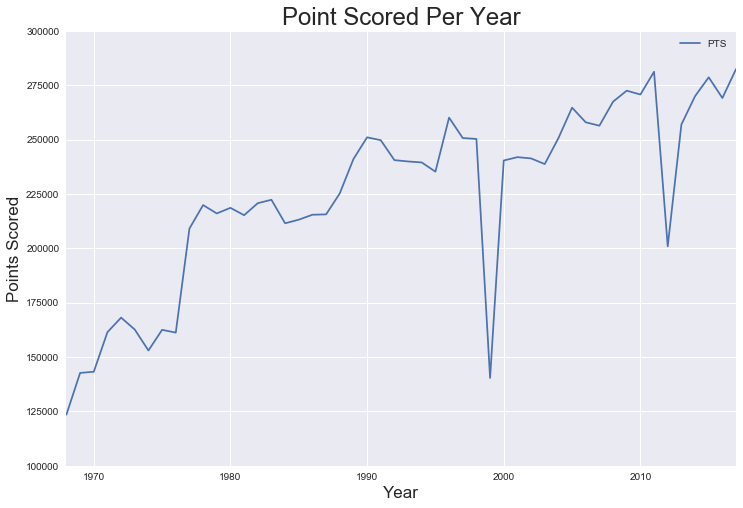

In [6]:
sumpts = stats82gms.groupby(['Year'])['PTS'].sum().reset_index()

fig,ax = plt.subplots()
sumpts.plot(x='Year',y='PTS',figsize = (12,8), ax=ax)
ax.set_ylim(100000,300000)
ax.set_title('Point Scored Per Year',size=24)
ax.set_xlabel('Year',size = 17)
ax.set_ylabel('Points Scored',size = 17)

**NOTES:** Besides in 1999 and 2012, you can see an overall increase in points over time since the incorporation of the 82 game season in the 1967-1968 season. The drastic declines in 1999 and 2012 were due to lockouts, where players refused to play and only ended up playing 50 and 66 games respectively. We were curious to see if the increase in points per season had to do with the installation of a three point line. Therefore, we found the numbers for three pointers attempted and ran a regression between points and three pointers attempted. Additionally, in 1995, the league decided to move the three point line closer, likely causing the point total to increase as a result, before dmoving it farther from the basket in 1998, leading to a slight decrease in total points.

Text(0, 0.5, '3 Pointers Attempted')

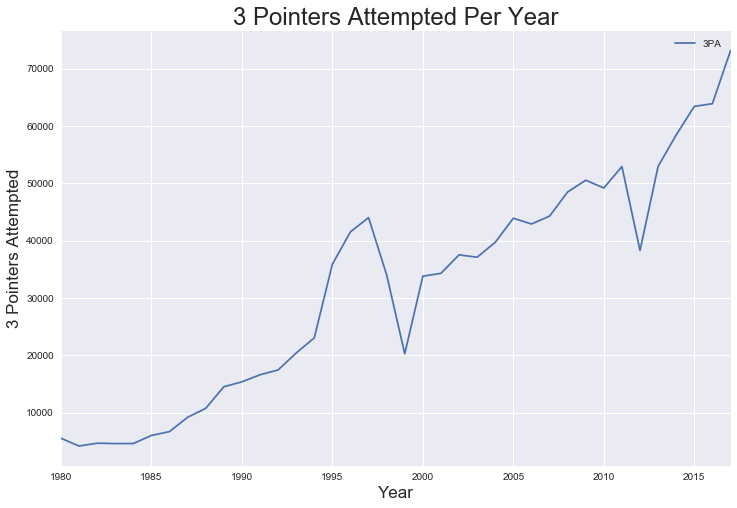

In [7]:
threes = stats3p.groupby(['Year'])['3PA'].sum().reset_index()

fig,ax = plt.subplots()
threes.plot(x='Year',y='3PA',figsize = (12,8), ax=ax)
#ax.set_ylim(100000,300000)
ax.set_title('3 Pointers Attempted Per Year',size=24)
ax.set_xlabel('Year',size = 17)
ax.set_ylabel('3 Pointers Attempted',size = 17)

In [8]:
pts_and_threes = sumpts.merge(threes)
pts_and_threes.columns = [['Year','PTS','ThreesAttempted']]
pts_to_threes = smf.ols('PTS ~ ThreesAttempted',data=pts_and_threes).fit()

In [9]:
pts_to_threes.rsquared

0.5157084644243529

In [10]:
print(pts_to_threes.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     38.34
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           3.86e-07
Time:                        19:02:40   Log-Likelihood:                -428.06
No. Observations:                  38   AIC:                             860.1
Df Residuals:                      36   BIC:                             863.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.104e+05   6007.836     

In [11]:
pts_and_threes['yhat'] = pts_to_threes.predict()

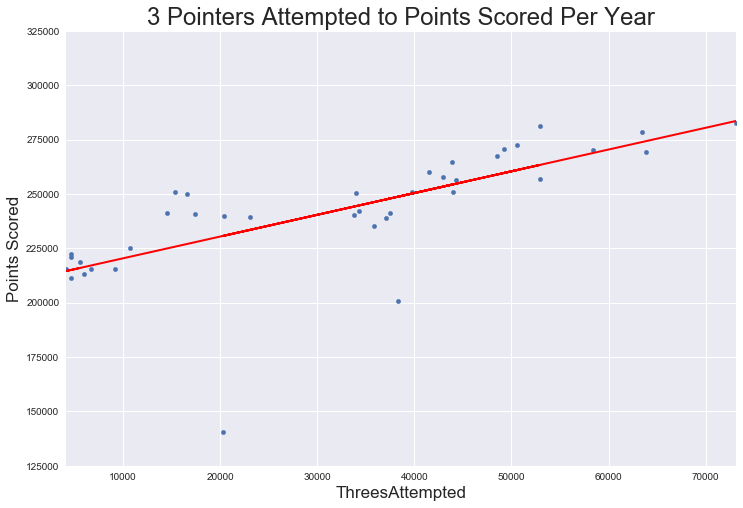

In [12]:
fig,ax = plt.subplots()
pts_and_threes.plot.scatter(y='PTS',x='ThreesAttempted',ax=ax,alpha=1, figsize = (12,8))
ax.set_ylim(125000,325000)
ax.set_title('3 Pointers Attempted to Points Scored Per Year',size=24)
ax.set_xlabel('3 Pointers Attempted',size = 17)
ax.set_ylabel('Points Scored',size = 17)
pts_and_threes.set_index('ThreesAttempted')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)


**NOTES:** There is a positive correlation between three pointers attempted and points scored. This shows that the extra point earned makes up for the lower probability of success, and that shooting more three pointers will potentially lead to scoring more points.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0, 0.5, 'Top 3% Usage Percentage')

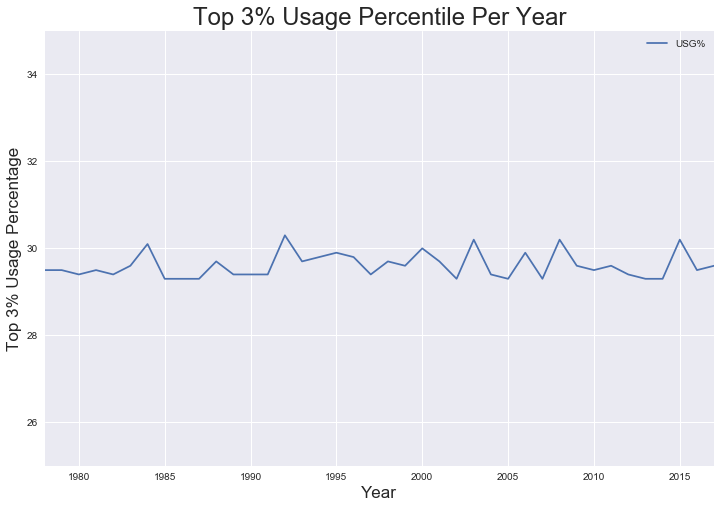

In [13]:
statsUSG = statsUSG.sort_values('USG%', ascending = False)
USG = (statsBPM.loc[statsBPM['USG%'] >= statsBPM['USG%'].quantile(0.97)][statsBPM['MP'] > 164]
       [['Year','USG%','BPM']])
# Adjust Minutes Played because some players barely played and saw a high usage rate as a result. 
USG = USG.groupby(['Year'])['USG%'].min().reset_index()
# By taking the minimum of the dataframe for each year, we are getting the true 97th percentile number. 
# We could not simply do == statsBPM['USG%'].quantile(0.97) because the value was not always exactly the 97th 
# percentile cut off, but by using the minimum we are getting the value that is the 97th percentile of the set.
fig,ax = plt.subplots()
USG.plot(x = 'Year', y = 'USG%',ax=ax, figsize = (12,8))
ax.set_ylim(25,35)
ax.set_title('Top 3% Usage Percentile Per Year',size=24)
ax.set_xlabel('Year',size = 17)
ax.set_ylabel('Top 3% Usage Percentage',size = 17)


**NOTES:**  We found this data extremely interesting. It is a popularly thought idea that the usage of the top players has grown over the years, as we often see players have "isolation" plays called for them where they try to beat the defender on their own. However, in reality the usage has actually not changed much over time and has remained relatively constant.

## Relationships Between Key Statistics
    In this section, we will look into the key statistics and how they correlate with one another. We will look at USG% to BPM, PER to BPM, BPM to Win Share, PER to Win Share, Assists to Win Share, Points to Win Share, Rebound to Win Share, Steals to Win Share, and Blocks to Win Share, comparing the correlations we find to determine 
    which statistics make the largest positive impact on a player's team wins.

### USG% to BPM

In [14]:
USGvBPM = stats17.loc[stats17['MP'] > 164][['Player','BPM','USG%']]
USGvBPM.columns = [['Player','BPM','USG']]
USG_to_BPM = smf.ols('BPM ~ USG',data=USGvBPM).fit()

In [15]:
USG_to_BPM.rsquared

0.13733100475378945

In [16]:
print(USG_to_BPM.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     64.63
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           9.96e-15
Time:                        19:02:46   Log-Likelihood:                -1000.2
No. Observations:                 408   AIC:                             2004.
Df Residuals:                     406   BIC:                             2012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9690      0.523     -9.505      0.0

In [17]:
USGvBPM['yhat'] = USG_to_BPM.predict()

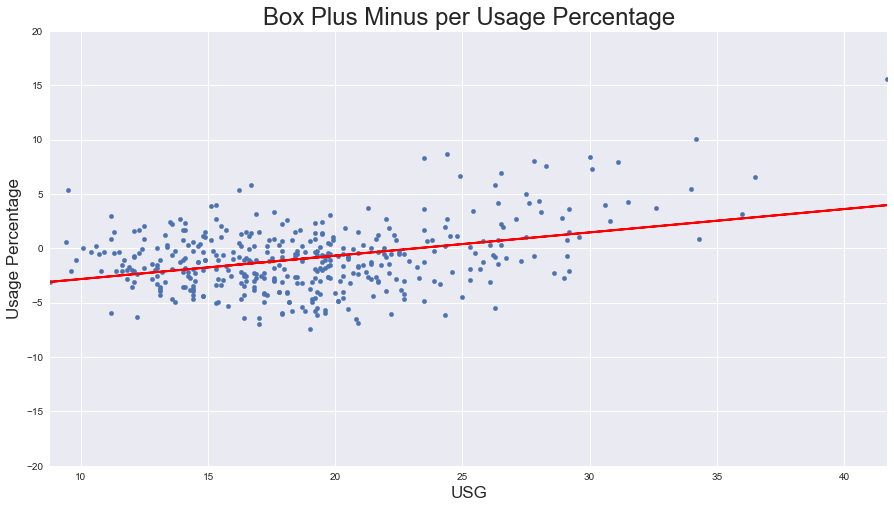

In [18]:
fig,ax = plt.subplots()
USGvBPM.plot.scatter(y='BPM',x='USG',ax=ax,alpha=1, figsize = (15,8))
ax.set_xlim(5,45)
ax.set_ylim(-20,20)
ax.set_title('Box Plus Minus per Usage Percentage',size=24)
ax.set_xlabel('Box Plus Minus',size = 17)
ax.set_ylabel('Usage Percentage',size = 17)
USGvBPM.set_index('USG')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** We were very curious to see whether the amount a player was used (Usage Percentage) would correlate to whether or not they had a positive impact on the score of the game for their team (Box Plus Minus). We hypothesized that the more a player was used, the higher their BPM would be, as the best players are usually the ones with the highest usage percentage. However, there is also the argument that a player who shoots too much or is used too much may negatively affect their team as well, and the legitamacy of this argument is backed up be the lower correlation between the two variables. However, there was a slight positive correlation, so the higher the usage, the more likely a player was to have a positive BPM.

### PER to BPM

In [19]:
PERvBPM = stats17.loc[stats17['MP'] > 164][['Player','BPM','PER']]
PER_to_BPM = smf.ols('BPM ~ PER',data=PERvBPM).fit()

In [20]:
PER_to_BPM.rsquared

0.6158725222128675

In [21]:
print(PER_to_BPM.summary())

                            OLS Regression Results                            
Dep. Variable:                    BPM   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     650.9
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           2.24e-86
Time:                        19:02:50   Log-Likelihood:                -835.15
No. Observations:                 408   AIC:                             1674.
Df Residuals:                     406   BIC:                             1682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.7516      0.284    -27.340      0.0

In [22]:
PERvBPM['yhat'] = PER_to_BPM.predict()

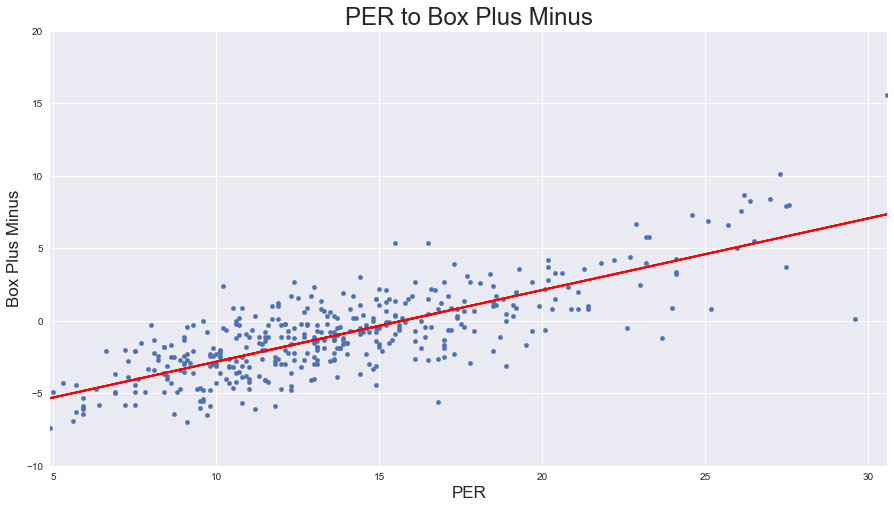

In [23]:
fig,ax = plt.subplots()
PERvBPM.plot.scatter(y='BPM',x='PER',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-10,20)
ax.set_title('PER to Box Plus Minus',size=24)
ax.set_ylabel('Box Plus Minus',size = 17)
ax.set_xlabel('Player Efficiency Rating',size = 17)
PERvBPM.set_index('PER')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** As expected, we found there to be a strong positive correlation between PER and BPM. This makes sense as a player with an "efficient" rating should be having a positive impact on their team. More interesting perhaps is our next calculations where we will be seeing how each statistic correlates to wins.

### BPM to Win Share

In [24]:
BPMvWS = stats17.loc[stats17['MP'] > 164][['Player','BPM','WS']]
BPM_to_WS = smf.ols('WS ~ BPM',data=BPMvWS).fit()

In [25]:
BPM_to_WS.rsquared

0.7210500149676784

In [26]:
print(BPM_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1049.
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          1.29e-114
Time:                        19:02:53   Log-Likelihood:                -757.70
No. Observations:                 408   AIC:                             1519.
Df Residuals:                     406   BIC:                             1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7873      0.080     47.113      0.0

In [27]:
BPMvWS['yhat'] = BPM_to_WS.predict()

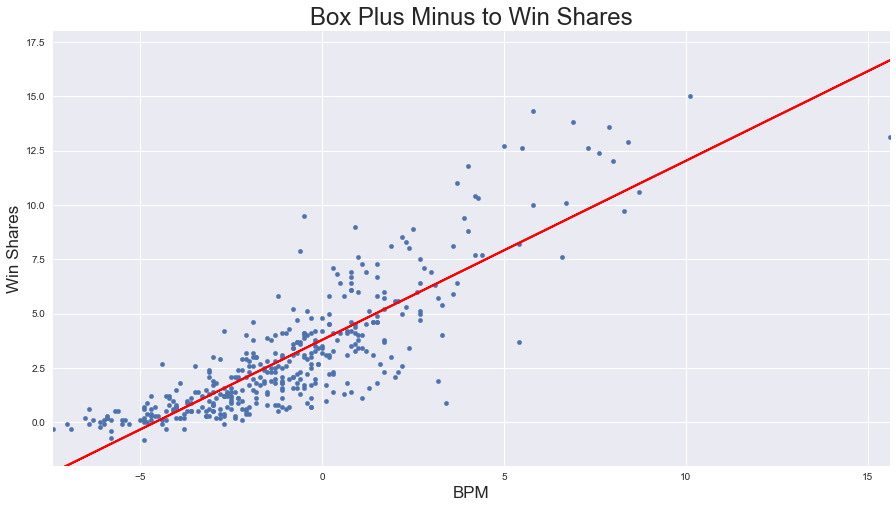

In [28]:
fig,ax = plt.subplots()
BPMvWS.plot.scatter(y='WS',x='BPM',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Box Plus Minus to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Box Plus Minus',size = 17)
BPMvWS.set_index('BPM')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** There is a very strong correlation between Bow Plus Minus and Win Shares. This shows that the more positive the point differential while a player is on the court, the more wins he will add for his team. This further shows the importance of the statistic BPM, as it has a high correlation with wins, which at the end of the day is what counts in the NBA.

### PER to Win Share

In [29]:
PERvWS = stats17.loc[stats17['MP'] > 164][['Player','PER','WS']]
PER_to_WS = smf.ols('WS ~ PER',data=PERvWS).fit()

In [30]:
PER_to_WS.rsquared

0.6316851696260053

In [31]:
print(PER_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     696.3
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           4.36e-90
Time:                        19:02:58   Log-Likelihood:                -814.40
No. Observations:                 408   AIC:                             1633.
Df Residuals:                     406   BIC:                             1641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6864      0.269    -13.681      0.0

In [32]:
PERvWS['yhat'] = PER_to_WS.predict()

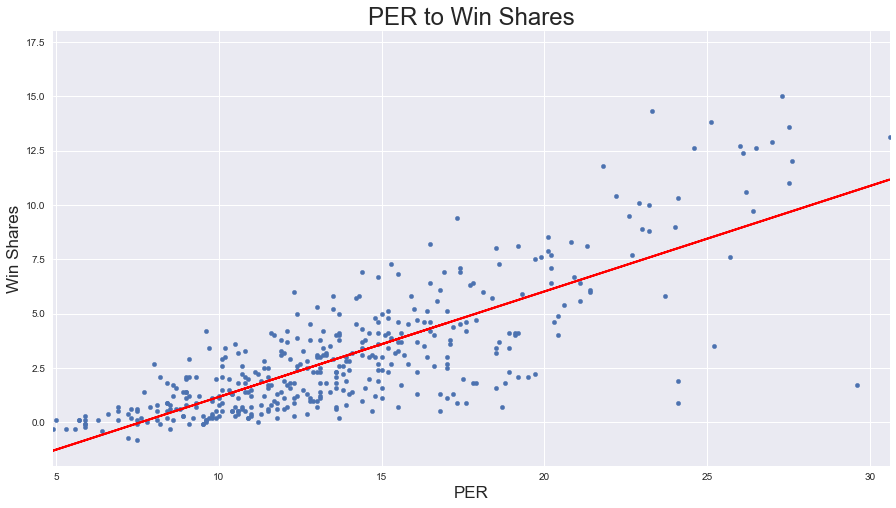

In [33]:
fig,ax = plt.subplots()
PERvWS.plot.scatter(y='WS',x='PER',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('PER to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Player Efficiency Rating',size = 17)
PERvWS.set_index('PER')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** There is a high correlation between PER and win shares, showing PER to be an extremely important statistic in determining a player's value. However, this correlation is lower than the correlation between BPM and Win shares, showing BPM to be a more valuable statistic in determining value.

### USG to Win Shares

In [34]:
USGvWS = stats17.loc[stats17['MP'] > 164][['Player','USG%','WS']]
USGvWS.columns = [['Player','USG','WS']]
USG_to_WS = smf.ols('WS ~ USG',data=USGvWS).fit()

In [35]:
USG_to_WS.rsquared

0.21910253645295275

In [36]:
print(USG_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     113.9
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           1.32e-23
Time:                        19:03:02   Log-Likelihood:                -967.70
No. Observations:                 408   AIC:                             1939.
Df Residuals:                     406   BIC:                             1947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9355      0.483     -4.009      0.0

In [37]:
USGvWS['yhat'] = USG_to_WS.predict()

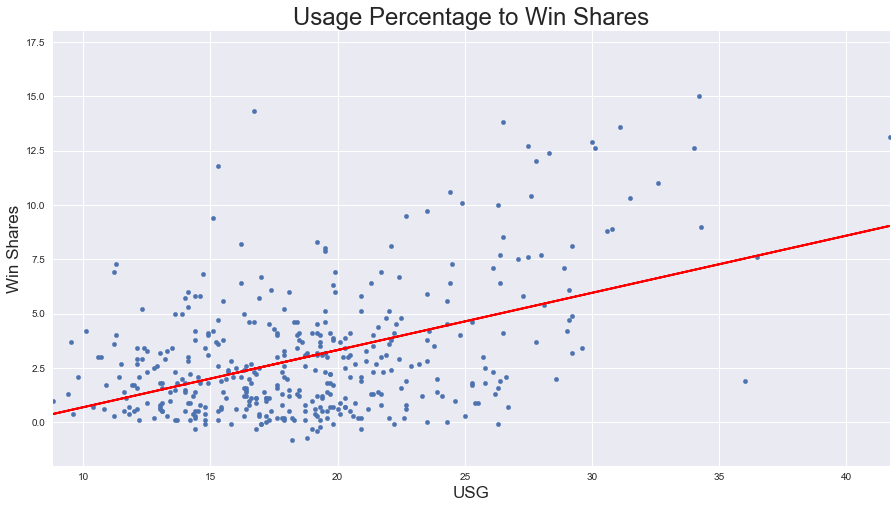

In [38]:
fig,ax = plt.subplots()
USGvWS.plot.scatter(y='WS',x='USG',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Usage Percentage to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Usage Percentage',size = 17)
USGvWS.set_index('USG')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** We found there was a positive correlation between Usage and Win Shares in 2017. However, its correlation was lower than both that of BPM and PER, showing it to be an inferior statistic in determining a player's value. Nevertheless, a player with a high usage rate does carry a higher value than a player with a low usage rate due to the positive correlation.

### Assists to Win Share

In [39]:
ASTvWS = stats17.loc[stats17['MP'] > 164][['Player','AST','WS']]
AST_to_WS = smf.ols('WS ~ AST',data=ASTvWS).fit()

In [40]:
AST_to_WS.rsquared

0.3718104864938575

In [41]:
print(AST_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     240.3
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           6.65e-43
Time:                        19:03:05   Log-Likelihood:                -923.31
No. Observations:                 408   AIC:                             1851.
Df Residuals:                     406   BIC:                             1859.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2854      0.161      7.972      0.0

In [42]:
ASTvWS['yhat'] = AST_to_WS.predict()

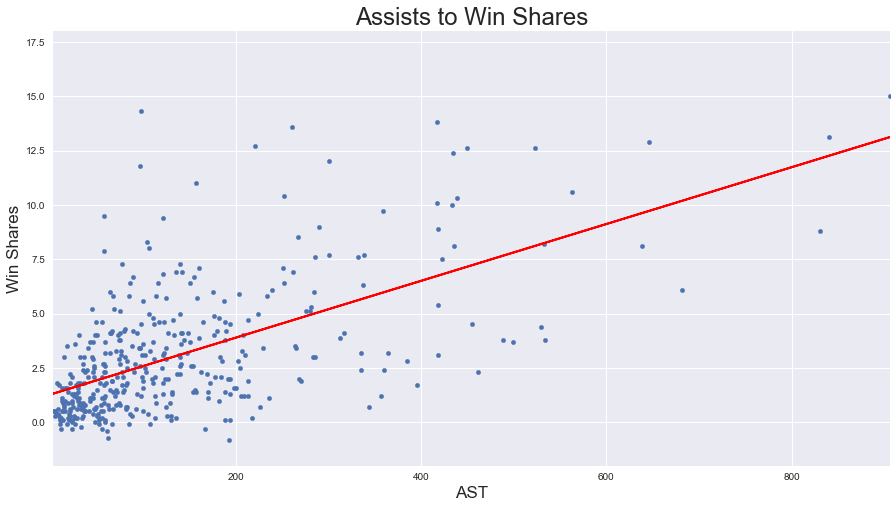

In [43]:
fig,ax = plt.subplots()
ASTvWS.plot.scatter(y='WS',x='AST',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Assists to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Assists',size = 17)
ASTvWS.set_index('AST')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** Out of rebounds, points, and assists, assists had the lowest correlation to win shares, showing it to be the least valuable of the 3 statistics. Nevertheless, its positive correlation does show that it carries some value in a player's contribution, but not as high a value as rebounds and points.

### Points to Win Share

In [44]:
PTSvWS = stats17.loc[stats17['MP'] > 164][['Player','PTS','WS']]
PTS_to_WS = smf.ols('WS ~ PTS',data=PTSvWS).fit()

In [45]:
PTS_to_WS.rsquared

0.7015367206417511

In [46]:
print(PTS_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     954.3
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          1.19e-108
Time:                        19:03:09   Log-Likelihood:                -771.50
No. Observations:                 408   AIC:                             1547.
Df Residuals:                     406   BIC:                             1555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1904      0.131     -1.452      0.1

In [47]:
PTSvWS['yhat'] = PTS_to_WS.predict()

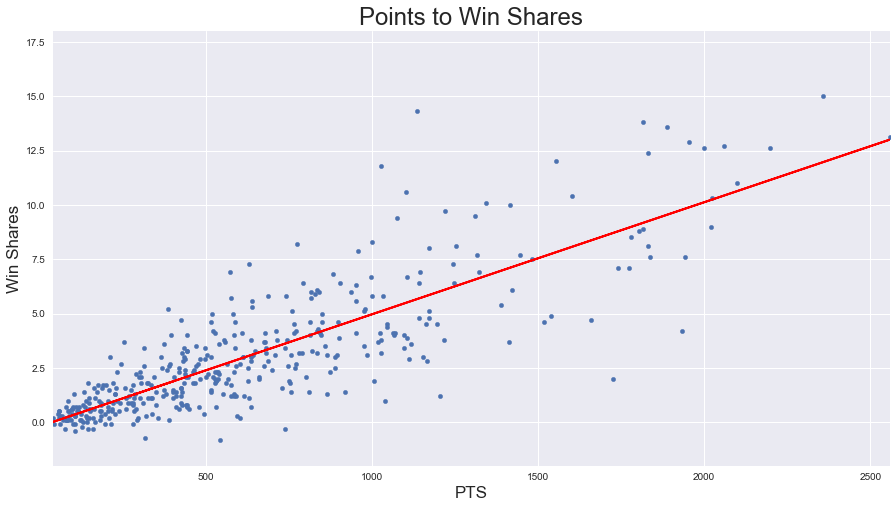

In [48]:
fig,ax = plt.subplots()
PTSvWS.plot.scatter(y='WS',x='PTS',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Points to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Points',size = 17)
PTSvWS.set_index('PTS')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** Points had the highest correlation out of assists, rebounds, and points, showing that players with high point totals carry a higher value than players with high assist and rebound values. This is to be expected, as wins are determined by the team with more points, not necessarily more assists or rebounds.

### Rebounds to Win Share

In [49]:
TRBvWS = stats17.loc[stats17['MP'] > 164][['Player','TRB','WS']]
TRB_to_WS = smf.ols('WS ~ TRB',data=TRBvWS).fit()

In [50]:
TRB_to_WS.rsquared

0.5491508080724545

In [51]:
print(TRB_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     494.5
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           3.13e-72
Time:                        19:03:12   Log-Likelihood:                -855.64
No. Observations:                 408   AIC:                             1715.
Df Residuals:                     406   BIC:                             1723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1673      0.162      1.034      0.3

In [52]:
TRBvWS['yhat'] = TRB_to_WS.predict()

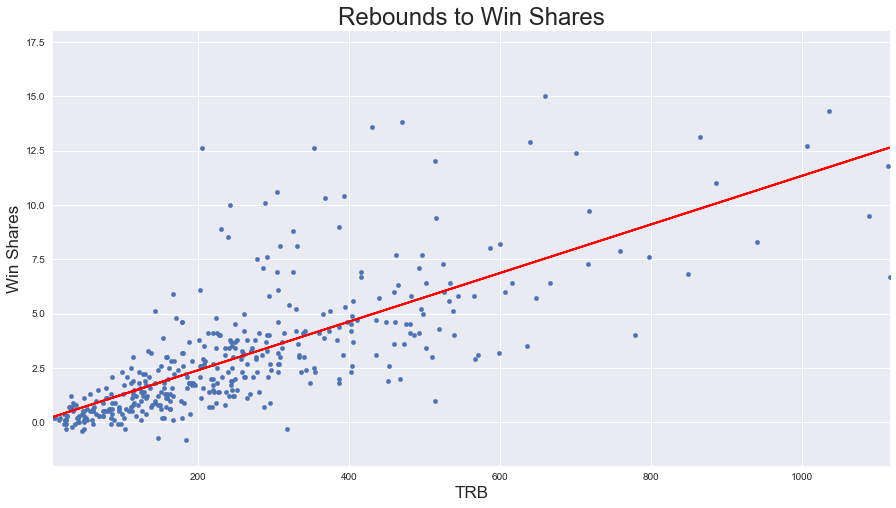

In [53]:
fig,ax = plt.subplots()
TRBvWS.plot.scatter(y='WS',x='TRB',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Rebounds to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Rebounds',size = 17)
TRBvWS.set_index('TRB')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** We found that Rebounds had a stronger correlation to Win Shares than Assists, supporting an argument that it is a more important statistic than Assists. Therefore, one can conclude that rebounds should carry over more value than assists, and players who have a higher number of rebounds should be valued higher than players who have the same relative number of assists.

### Steals to Win Share

In [54]:
STLvWS = stats17.loc[stats17['MP'] > 164][['Player','STL','WS']]
STL_to_WS = smf.ols('WS ~ STL',data=STLvWS).fit()

In [55]:
STL_to_WS.rsquared

0.45671728900372566

In [56]:
print(STL_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     341.3
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           9.48e-56
Time:                        19:03:16   Log-Likelihood:                -893.69
No. Observations:                 408   AIC:                             1791.
Df Residuals:                     406   BIC:                             1799.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1571      0.189      0.831      0.4

In [57]:
STLvWS['yhat'] = STL_to_WS.predict()

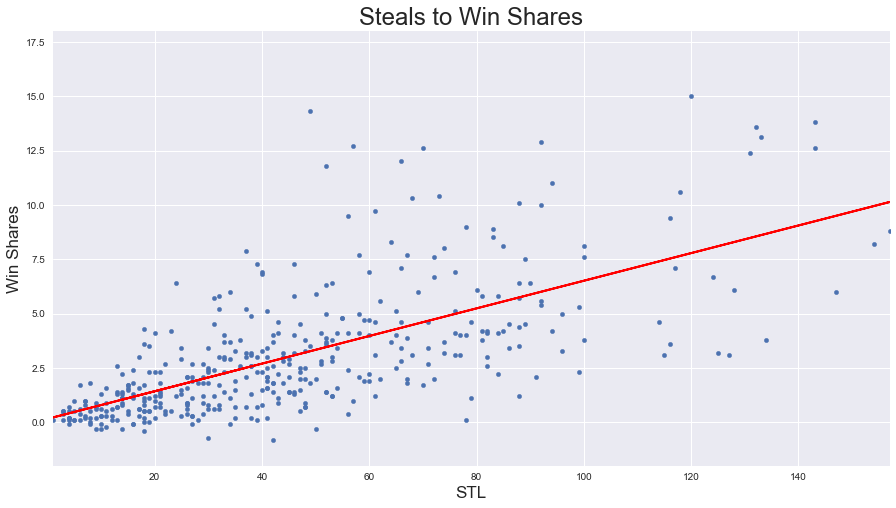

In [58]:
fig,ax = plt.subplots()
STLvWS.plot.scatter(y='WS',x='STL',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Steals to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Steals',size = 17)
STLvWS.set_index('STL')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

**NOTES:** Out of our defensive statistics, we found that Steals had a stronger correlation to Win Shares than blocks. This makes sense because a steal translates to possession and a scoring opportunity for the team causing the steal, while blocks often do not change possession. (see next graph)

### Blocks to Win Share

In [59]:
BLKvWS = stats17.loc[stats17['MP'] > 164][['Player','BLK','WS']]
BLK_to_WS = smf.ols('WS ~ BLK',data=BLKvWS).fit()

In [60]:
BLK_to_WS.rsquared

0.3171574808560784

In [61]:
print(BLK_to_WS.summary())

                            OLS Regression Results                            
Dep. Variable:                     WS   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     188.6
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           1.63e-35
Time:                        19:03:20   Log-Likelihood:                -940.33
No. Observations:                 408   AIC:                             1885.
Df Residuals:                     406   BIC:                             1893.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5008      0.164      9.151      0.0

In [62]:
BLKvWS['yhat'] = BLK_to_WS.predict()

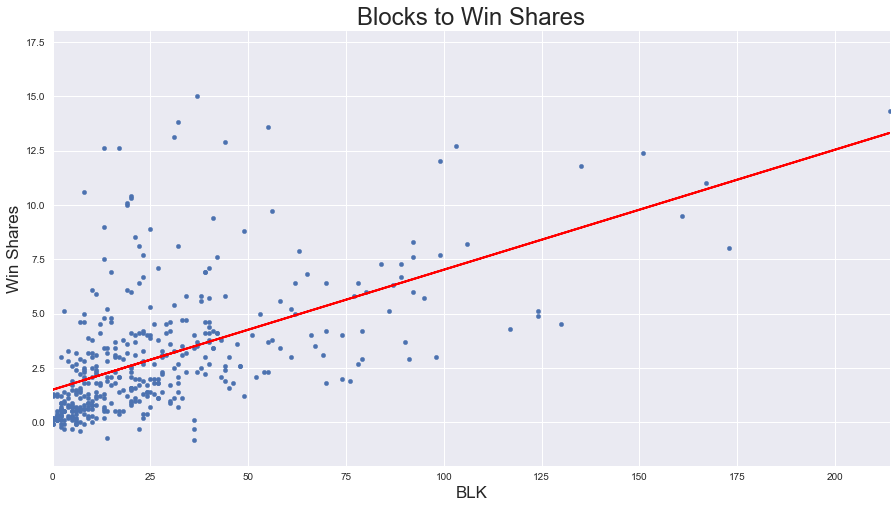

In [63]:
fig,ax = plt.subplots()
BLKvWS.plot.scatter(y='WS',x='BLK',ax=ax,alpha=1, figsize = (15,8))
ax.set_ylim(-2,18)
ax.set_title('Blocks to Win Shares',size=24)
ax.set_ylabel('Win Shares',size = 17)
ax.set_xlabel('Blocks',size = 17)
BLKvWS.set_index('BLK')['yhat'].plot(ax=ax,color='red',lw=2, legend=False)

## Calculations Regarding Special Performers and Player Values
    In this section, we will look at the statistics of players who are not receiving many minutes but are still 
    putting up large numbers, players who are young but effective, and players with high BPM, USG%, and PER 
    statistics. We will adjust for players who have high BPM, USG%, and PER due to low minutes played by ensuring 
    all players average at least 2 minutes per game. We will compare players as a whole, as well as by position, 
    eventually taking into account a player's salary.

### Assists

#### Low Minutes, High Assists

In [64]:
LowMinHiAST = (stats17.loc[stats17['MP'] < stats17['MP'].median()][stats17['AST'] > stats17['AST'].median()]
               [['Player','Pos','Age','AST','MP','Salary']])
Top10LowMinHiAST = LowMinHiAST.sort_values('AST', ascending = False).head(10)
Top10LowMinHiAST

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Player,Pos,Age,AST,MP,Salary
606,Tyler Ulis,PG,21.0,226.0,1123.0,918369
33,J.J. Barea,PG,32.0,193.0,771.0,4096950
378,Jeremy Lin,PG,28.0,184.0,883.0,11483254
193,Yogi Ferrell,PG,23.0,172.0,1197.0,239767
344,Tyus Jones,PG,20.0,156.0,774.0,1339680
635,David West,C,36.0,151.0,854.0,1551659
257,Devin Harris,PG,33.0,136.0,1087.0,4228000
605,Beno Udrih,PG,34.0,131.0,560.0,1551659
123,Semaj Christon,PG,24.0,130.0,973.0,543471
352,Brandon Knight,SG,25.0,130.0,1140.0,12606250


**NOTES:** This shows high value players who are potentially underplayed in terms of their production of Assists. Tyler Ullis, Yogi Ferrell, and Tyus Jones seem to be excellent potential targets, as they are under 24 years old and already putting up great numbers despite inexperience, low minutes, and low salary. These attributes make them extremely valuable, as they offer a high, long-term reward for a low cost.

Text(0.5, 0, 'Players')

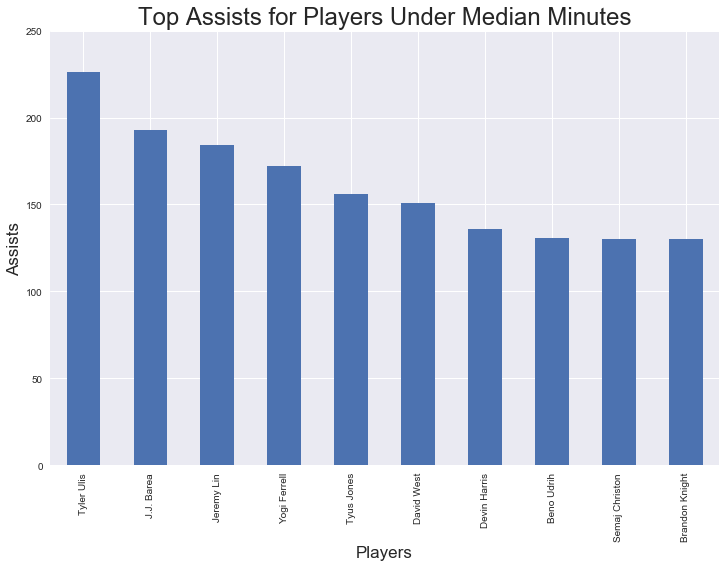

In [65]:
fig,ax = plt.subplots()
Top10LowMinHiAST.plot.bar(x='Player',y='AST',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,250)
ax.set_title('Top Assists for Players Under Median Minutes',size=24)
ax.set_ylabel('Assists',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Assists

In [66]:
LowSALHiAST = stats17.loc[stats17['Salary'] < stats17['Salary'].median()][['Player','Pos','Age','AST','Salary']]
Top10LowSALHiAST = LowSALHiAST.sort_values('AST', ascending = False).head(10)
Top10LowSALHiAST

,Player,Pos,Age,AST,Salary
397,T.J. McConnell,PG,24.0,534.0,874636
476,Elfrid Payton,PG,22.0,529.0,2613600
529,Dennis Schroder,PG,23.0,499.0,2708582
22,Giannis Antetokounmpo,SF,22.0,434.0,2995421
333,Nikola Jokic,C,21.0,359.0,1358500
365,Ty Lawson,PG,29.0,335.0,1315448
203,Tim Frazier,PG,26.0,335.0,2090000
79,Malcolm Brogdon,SG,24.0,317.0,925000
396,C.J. McCollum,SG,25.0,285.0,3219579
481,Mason Plumlee,C,26.0,284.0,2328530


**NOTES:** This shows the assist numbers for low cost players which is extremely valuable to GMs because it provides a high performance for a minimal salary expense. T.J. McConnell and Malcolm Brogdon are very appealing to teams, as they put up high assist totals while costing under $1 million, and being under 25 years old, they offer an additional long-term value to their teams.

Text(0.5, 0, 'Players')

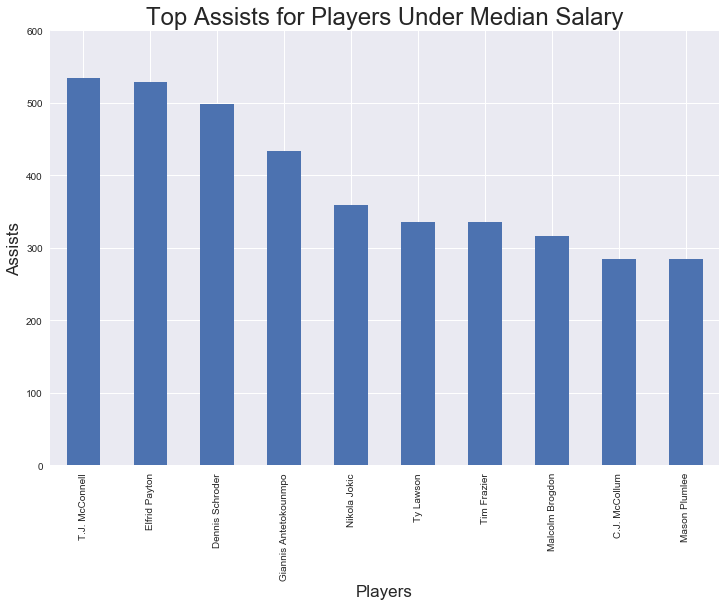

In [67]:
fig,ax = plt.subplots()
Top10LowSALHiAST.plot.bar(x='Player',y='AST',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,600)
ax.set_title('Top Assists for Players Under Median Salary',size=24)
ax.set_ylabel('Assists',size = 17)
ax.set_xlabel('Players',size = 17)

#### Assists per Minute (Assist Efficiency)

In [68]:
stats17['ASTperMP'] = stats17['AST']/stats17['MP']
ASTperMin= stats17.loc[stats17['MP'] > 164][['Player','Pos','Age','AST','MP','ASTperMP','Salary']]
Top10ASTperMin = ASTperMin.sort_values('ASTperMP', ascending = False).head(10)
Top10ASTperMin
# We filtered our data to only include players with more than 2 minutes played per game in order for the most accurate results.

,Player,Pos,Age,AST,MP,ASTperMP,Salary
253,James Harden,PG,27.0,906.0,2947.0,0.307431,26540100
636,Russell Westbrook,PG,28.0,840.0,2802.0,0.299786,26540100
471,Chris Paul,PG,31.0,563.0,1921.0,0.293077,22868827
622,John Wall,PG,26.0,831.0,2836.0,0.293018,16957900
521,Ricky Rubio,PG,26.0,682.0,2469.0,0.276225,13550000
397,T.J. McConnell,PG,24.0,534.0,2133.0,0.250352,874636
33,J.J. Barea,PG,32.0,193.0,771.0,0.250324,4096950
515,Rajon Rondo,PG,30.0,461.0,1843.0,0.250136,14000000
576,Jeff Teague,PG,28.0,639.0,2657.0,0.240497,8800000
605,Beno Udrih,PG,34.0,131.0,560.0,0.233929,1551659


**NOTES:** TJ McConnell appears to be highly undervalued, as he is in the top ten for Assists per minute, but does not even make 1 million dollars. There is a low cost, high return value for teams to go for this type of player. Additionally, TJ McConnell is only 24, adding to his value by the possibility of long term availability.

Text(0.5, 0, 'Players')

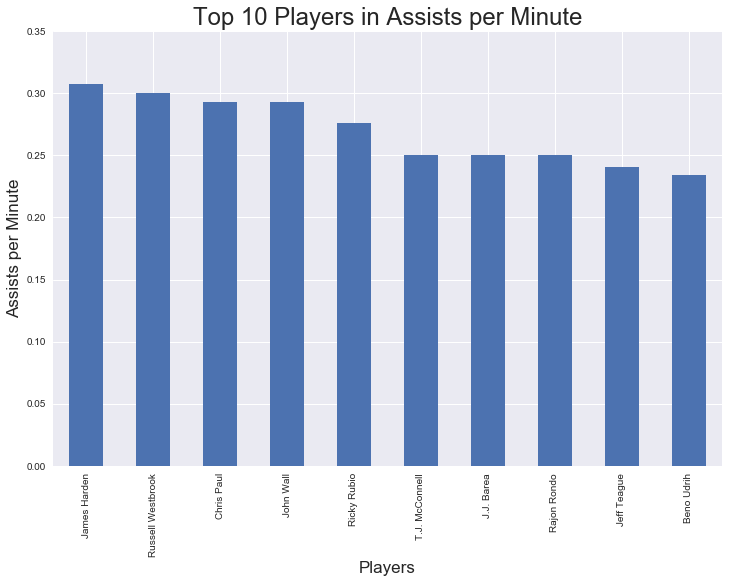

In [69]:
fig,ax = plt.subplots()
Top10ASTperMin.plot.bar(x='Player',y='ASTperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,0.35)
ax.set_title('Top 10 Players in Assists per Minute',size=24)
ax.set_ylabel('Assists per Minute',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Assists Per Minute

In [70]:
stats17['ASTperMP'] = stats17['AST']/stats17['MP']
ASTperMin2= (stats17.loc[stats17['MP'] > 164][stats17['Salary'] < stats17['Salary'].median()]
             [['Player','Pos','Age','AST','MP','ASTperMP','Salary']])
Top10ASTperMin2 = ASTperMin2.sort_values('ASTperMP', ascending = False).head(10)
Top10ASTperMin2
# We filtered our data to only include players with more than 2 minutes played per game in order for the most accurate results.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,AST,MP,ASTperMP,Salary
397,T.J. McConnell,PG,24.0,534.0,2133.0,0.250352,874636
605,Beno Udrih,PG,34.0,131.0,560.0,0.233929,1551659
203,Tim Frazier,PG,26.0,335.0,1525.0,0.219672,2090000
293,Marcelo Huertas,PG,33.0,52.0,237.0,0.219409,1500000
476,Elfrid Payton,PG,22.0,529.0,2412.0,0.219320,2613600
344,Tyus Jones,PG,20.0,156.0,774.0,0.201550,1339680
606,Tyler Ulis,PG,21.0,226.0,1123.0,0.201247,918369
529,Dennis Schroder,PG,23.0,499.0,2485.0,0.200805,2708582
365,Ty Lawson,PG,29.0,335.0,1732.0,0.193418,1315448
635,David West,C,36.0,151.0,854.0,0.176815,1551659


**NOTES:** This shows the players who cost less than the median salary who provide the most efficiency in dishing out assists. Once again, TJ McConnell looks to be an undervalued asset, and Elfrid Payton, Tyus Jones, and Tyler Ulis are also highly valuable due to their youth and low salaries.

Text(0.5, 0, 'Players')

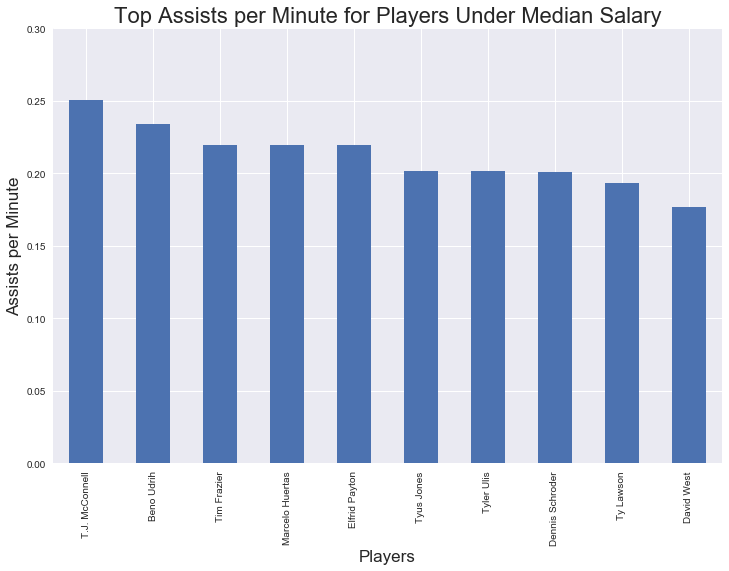

In [71]:
fig,ax = plt.subplots()
Top10ASTperMin2.plot.bar(x='Player',y='ASTperMP',ax=ax,figsize=(12,8),legend = False)
ax.set_ylim(0,.3)
ax.set_title('Top Assists per Minute for Players Under Median Salary',size=22)
ax.set_ylabel('Assists per Minute',size = 17)
ax.set_xlabel('Players',size = 17)

### Points

#### Low Minutes, High Points

In [72]:
LowMinHiPTS = (stats17.loc[stats17['MP'] < stats17['MP'].median()][stats17['PTS'] > stats17['PTS'].median()]
               [['Player','Pos','Age','PTS','MP','Salary']])
Top10LowMinHiPTS = LowMinHiPTS.sort_values('PTS', ascending = False).head(10)
Top10LowMinHiPTS

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Player,Pos,Age,PTS,MP,Salary
177,Joel Embiid,C,22.0,627.0,786.0,4826160
280,Nene Hilario,C,34.0,609.0,1198.0,2898000
359,Jeremy Lamb,SG,24.0,603.0,1143.0,6511628
352,Brandon Knight,SG,25.0,595.0,1140.0,12606250
457,Jahlil Okafor,C,21.0,590.0,1134.0,4788840
213,Rudy Gay,SF,30.0,562.0,1013.0,13333333
288,Richaun Holmes,C,23.0,559.0,1193.0,1025831
148,Troy Daniels,SG,25.0,551.0,1183.0,3332940
316,Al Jefferson,C,32.0,535.0,931.0,10230179
49,Michael Beasley,PF,28.0,528.0,935.0,1403611


**NOTES:** This shows the players who receive less than the median minutes played who produce the most points. Joel Embiid, Jahlil Okafor, and Richaun Holmes seem to be very valuable players who are on low cost salaries and putting up high numbers despite fewer minutes and young ages. Perhaps the best target in this group is Richaun Holmes, who is only 23 years old and costs less than $1 million.

Text(0.5, 0, 'Players')

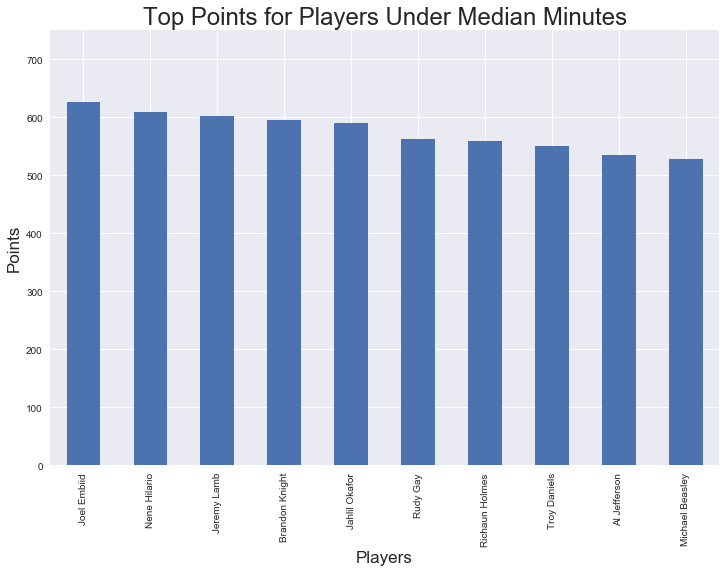

In [73]:
fig,ax = plt.subplots()
Top10LowMinHiPTS.plot.bar(x='Player',y='PTS',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,750)
ax.set_title('Top Points for Players Under Median Minutes',size=24)
ax.set_ylabel('Points',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Points

In [74]:
LowSALHiPTS = stats17.loc[stats17['Salary'] < stats17['Salary'].median()][['Player','Pos','Age','PTS','Salary']]
Top10LowSALHiPTS = LowSALHiPTS.sort_values('PTS', ascending = False).head(10)
Top10LowSALHiPTS

,Player,Pos,Age,PTS,Salary
396,C.J. McCollum,SG,25.0,1837.0,3219579
22,Giannis Antetokounmpo,SF,22.0,1832.0,2995421
73,Devin Booker,SG,20.0,1726.0,2223600
529,Dennis Schroder,PG,23.0,1414.0,2708582
333,Nikola Jokic,C,21.0,1221.0,1358500
604,Myles Turner,C,20.0,1173.0,2463840
252,Tim Hardaway,SG,24.0,1143.0,2281605
226,Rudy Gobert,C,24.0,1137.0,2121288
476,Elfrid Payton,PG,22.0,1046.0,2613600
527,Dario Saric,PF,22.0,1040.0,2318280


**NOTES:**  Each of these players show immensely high values to teams, as they are low cost, all under the age of 26, and very effective scorers. Devin Booker is extremely impressive, as he is scoring at an impressive rate at the age of 20. If a team could get Devin Booker, they should attempt to at even a high cost.

Text(0.5, 0, 'Players')

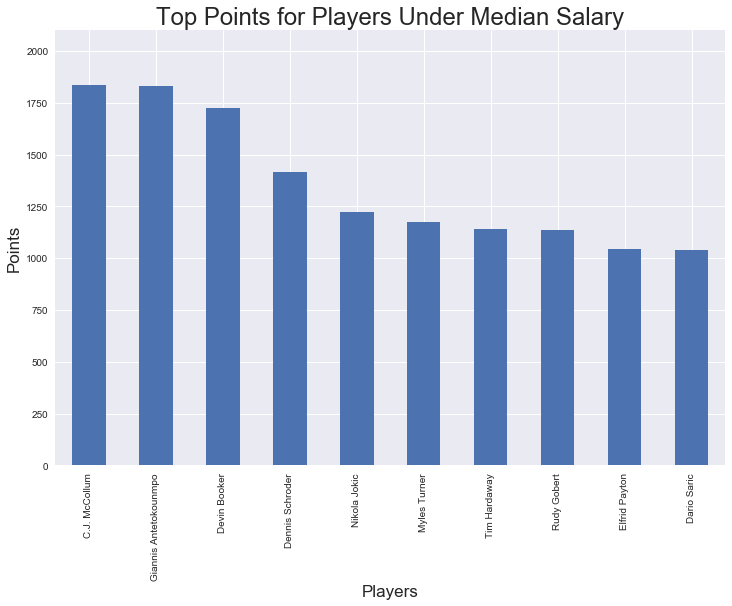

In [75]:
fig,ax = plt.subplots()
Top10LowSALHiPTS.plot.bar(x='Player',y='PTS',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,2100)
ax.set_title('Top Points for Players Under Median Salary',size=24)
ax.set_ylabel('Points',size = 17)
ax.set_xlabel('Players',size = 17)

#### Points per Minute (Scoring Efficiency)

In [76]:
stats17['PTSperMP'] = stats17['PTS']/stats17['MP']
PTSperMin= stats17.loc[stats17['MP'] > 164][['Player','Pos','Age','PTS','MP','PTSperMP','Salary']]
Top10PTSperMin = PTSperMin.sort_values('PTSperMP', ascending = False).head(10)
Top10PTSperMin
# We filtered our data to only include players with more than 2 minutes played per game in order for the most accurate results.

,Player,Pos,Age,PTS,MP,PTSperMP,Salary
636,Russell Westbrook,PG,28.0,2558.0,2802.0,0.912919,26540100
580,Isaiah Thomas,PG,27.0,2199.0,2569.0,0.855975,6587132
253,James Harden,PG,27.0,2356.0,2947.0,0.799457,26540100
177,Joel Embiid,C,22.0,627.0,786.0,0.797710,4826160
137,DeMarcus Cousins,C,26.0,1942.0,2465.0,0.787830,16957900
149,Anthony Davis,C,23.0,2099.0,2708.0,0.775111,22116750
157,DeMar DeRozan,SG,27.0,2020.0,2620.0,0.770992,26540100
370,Kawhi Leonard,SF,25.0,1888.0,2474.0,0.763137,17638063
147,Stephen Curry,PG,28.0,1999.0,2638.0,0.757771,12112359
377,Damian Lillard,PG,26.0,2024.0,2694.0,0.751299,24328425


**NOTES:** This shows the players who score most efficiently. Isaiah Thomas and Joel Embiid are in the top 10, but make less than 10 million, showing that they may be undervalued and more valuable to a team than what appears. Joel Embiid also adds future value, as he is only 22 years old.

Text(0.5, 0, 'Players')

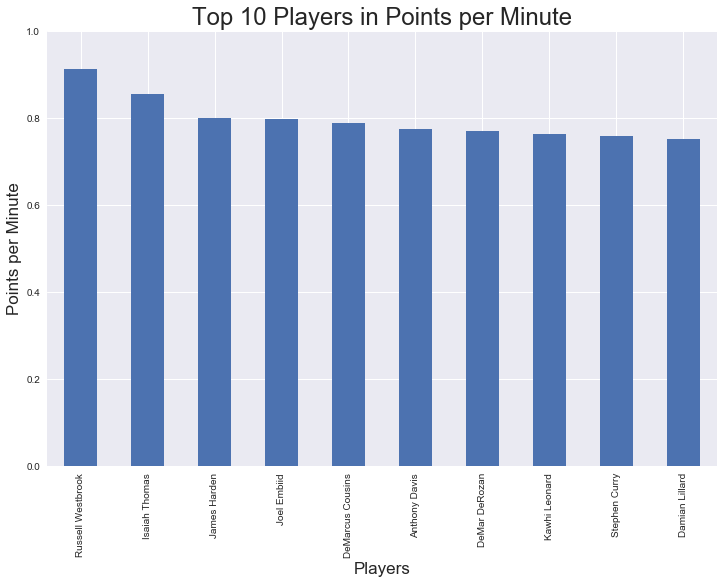

In [77]:
fig,ax = plt.subplots()
Top10PTSperMin.plot.bar(x='Player',y='PTSperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,1)
ax.set_title('Top 10 Players in Points per Minute',size=24)
ax.set_ylabel('Points per Minute',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Points per Minute

In [78]:
stats17['PTSperMP'] = stats17['PTS']/stats17['MP']
PTSperMin2= (stats17.loc[stats17['MP'] > 164][stats17['Salary'] < stats17['Salary'].median()]
             [['Player','Pos','Age','PTS','MP','PTSperMP','Salary']])
Top10PTSperMin2 = PTSperMin2.sort_values('PTSperMP', ascending = False).head(10)
Top10PTSperMin2
# We filtered our data to only include players with more than 2 minutes played per game in order for the most accurate results.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,PTS,MP,PTSperMP,Salary
396,C.J. McCollum,SG,25.0,1837.0,2796.0,0.657010,3219579
22,Giannis Antetokounmpo,SF,22.0,1832.0,2845.0,0.643937,2995421
407,JaVale McGee,C,29.0,472.0,739.0,0.638701,1403611
380,Shawn Long,C,24.0,148.0,234.0,0.632479,96969
73,Devin Booker,SG,20.0,1726.0,2730.0,0.632234,2223600
143,Jordan Crawford,SG,28.0,267.0,442.0,0.604072,234915
333,Nikola Jokic,C,21.0,1221.0,2038.0,0.599117,1358500
529,Dennis Schroder,PG,23.0,1414.0,2485.0,0.569014,2708582
49,Michael Beasley,PF,28.0,528.0,935.0,0.564706,1403611
550,Marreese Speights,C,29.0,711.0,1286.0,0.552877,1403611


**NOTES:** Shawn Long and Jordan Crawford both play less than 500 minutes but average more than .6 points per minute. This shows that they might deserve to be played more minutes. Shawn Long is 24 and does not even cost $100,000, so he is a high value player at an unbelievably low cost, who could be good option if a team was looking for role player at Center.

Text(0.5, 0, 'Players')

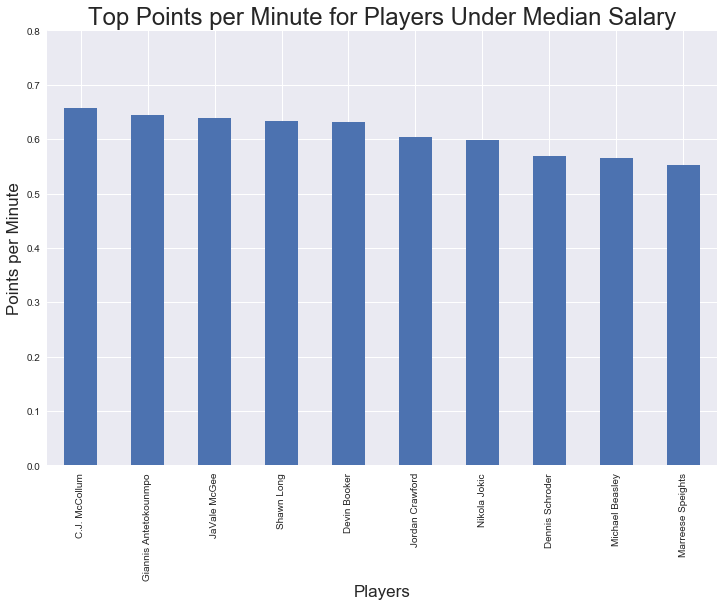

In [79]:
fig,ax = plt.subplots()
Top10PTSperMin2.plot.bar(x='Player',y='PTSperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,.8)
ax.set_title('Top Points per Minute for Players Under Median Salary',size=24)
ax.set_ylabel('Points per Minute',size = 17)
ax.set_xlabel('Players',size = 17)

### Rebounds

#### Low Minutes, High Rebounds

In [80]:
LowMinHiTRB = (stats17.loc[stats17['MP'] < stats17['MP'].median()][stats17['TRB'] > stats17['TRB'].median()]
               [['Player','Pos','Age','Tm','TRB','MP','Salary']])
Top10LowMinHiTRB = LowMinHiTRB.sort_values('TRB', ascending = False).head(10)
Top10LowMinHiTRB

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Player,Pos,Age,Tm,TRB,MP,Salary
445,Joakim Noah,C,31.0,NYK,402.0,1015.0,17000000
61,Tarik Black,C,25.0,LAL,342.0,1091.0,6191000
45,Aron Baynes,C,30.0,DET,333.0,1163.0,6500000
506,Willie Reed,C,26.0,MIA,332.0,1031.0,1015696
288,Richaun Holmes,C,23.0,PHI,311.0,1193.0,1025831
191,Cristiano Felicio,C,24.0,CHI,311.0,1040.0,874636
413,Salah Mejri,C,30.0,DAL,308.0,905.0,874636
189,Derrick Favors,PF,25.0,UTA,305.0,1186.0,11050000
489,Bobby Portis,PF,21.0,CHI,296.0,1000.0,1453680
270,John Henson,C,26.0,MIL,295.0,1123.0,12517606


**NOTES:** Richaun Holmes, Christiano Fellicio, and Bobby Portis seem to be undervalued and underplayed, as they put up high rebounding numbers despite few minutes and low salaries. Additionally, they are all under 25 years old, adding to their value by promising a potential future return.

Text(0.5, 0, 'Players')

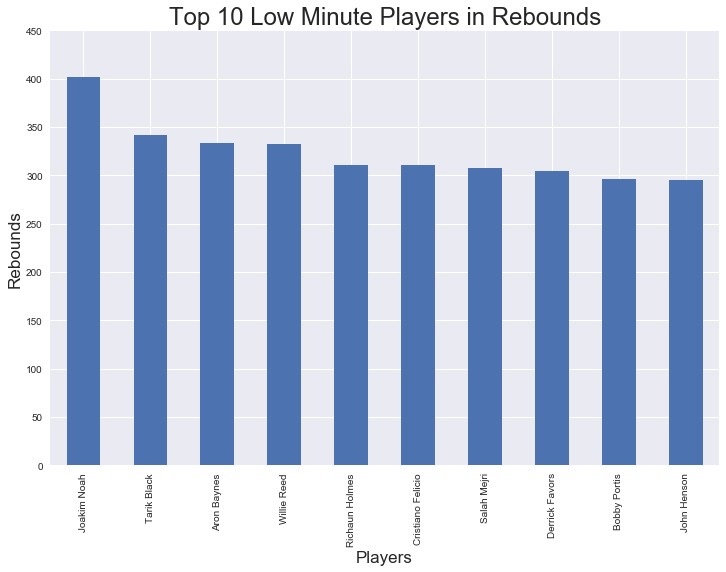

In [81]:
fig,ax = plt.subplots()
Top10LowMinHiTRB.plot.bar(x='Player',y='TRB',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,450)
ax.set_title('Top 10 Low Minute Players in Rebounds',size=24)
ax.set_ylabel('Rebounds',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Rebounds

In [82]:
LowSALHiTRB = stats17.loc[stats17['Salary'] < stats17['Salary'].median()][['Player','Pos','Age','TRB','Salary']]
Top10LowSALHiTRB = LowSALHiTRB.sort_values('TRB', ascending = False).head(10)
Top10LowSALHiTRB

,Player,Pos,Age,TRB,Salary
226,Rudy Gobert,C,24.0,1035.0,2121288
333,Nikola Jokic,C,21.0,718.0,1358500
22,Giannis Antetokounmpo,SF,22.0,700.0,2995421
160,Gorgui Dieng,PF,27.0,647.0,2348783
7,Steven Adams,C,23.0,615.0,3140517
481,Mason Plumlee,C,26.0,606.0,2328530
604,Myles Turner,C,20.0,587.0,2463840
247,JaMychal Green,PF,26.0,544.0,980431
106,Clint Capela,C,22.0,526.0,1296240
527,Dario Saric,PF,22.0,513.0,2318280


**NOTES:** Rudy Gobert, Nikola Jokic, Giannis Antetokounmpo, and Myles Turner are very impressive in this chart, as they are all under 25, cost less than $3 million, and are some of the best rebounders in the league. Therefore, teams should target these players and the others on the list to get high, long-term value for a low cost. Rudy Gobert had by far the highest numbers, and is likely the most valuable on the chart.

Text(0.5, 0, 'Players')

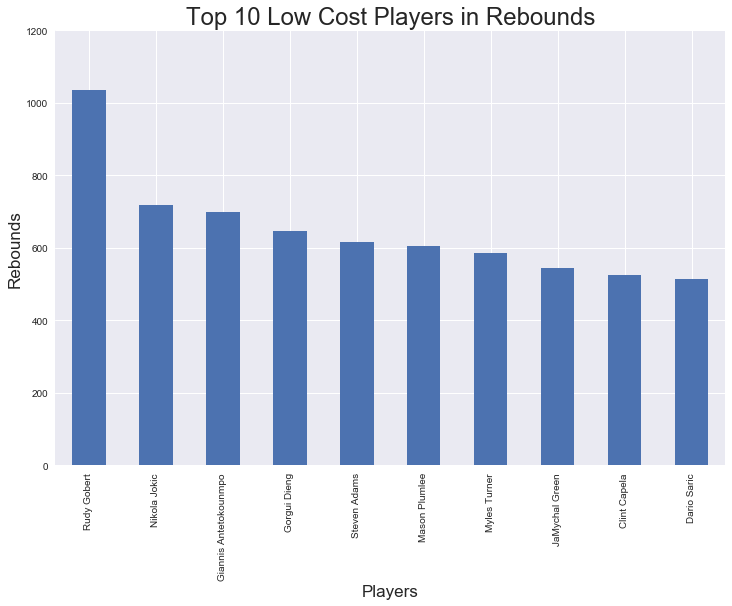

In [83]:
fig,ax = plt.subplots()
Top10LowSALHiTRB.plot.bar(x='Player',y='TRB',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,1200)
ax.set_title('Top 10 Low Cost Players in Rebounds',size=24)
ax.set_ylabel('Rebounds',size = 17)
ax.set_xlabel('Players',size = 17)

#### Rebounds per Minute (Rebounding Efficiency)

In [84]:
stats17['TRBperMP'] = stats17['TRB']/stats17['MP']
TRBperMin= stats17.loc[stats17['MP'] > 164][['Player','Pos','Age','Tm','TRB','MP','TRBperMP','Salary']]
Top10TRBperMin = TRBperMin.sort_values('TRBperMP', ascending = False).head(10)
Top10TRBperMin
# We filtered our data to only include players with more than 2 minutes played per game in order for the most accurate results.

,Player,Pos,Age,Tm,TRB,MP,TRBperMP,Salary
164,Andre Drummond,C,23.0,DET,1116.0,2409.0,0.463263,22116750
391,Boban Marjanovic,C,28.0,DET,130.0,293.0,0.443686,7000000
345,DeAndre Jordan,C,28.0,LAC,1114.0,2570.0,0.433463,21165675
639,Hassan Whiteside,C,27.0,MIA,1088.0,2513.0,0.432949,22116750
292,Dwight Howard,C,31.0,ATL,940.0,2199.0,0.427467,23180275
119,Tyson Chandler,C,34.0,PHO,539.0,1298.0,0.415254,12415000
642,Alan Williams,C,24.0,PHO,292.0,708.0,0.412429,874636
513,Thomas Robinson,PF,25.0,LAL,223.0,560.0,0.398214,1050961
445,Joakim Noah,C,31.0,NYK,402.0,1015.0,0.396059,17000000
272,Willy Hernangomez,C,22.0,NYK,502.0,1324.0,0.379154,1375000


**NOTES:** Alan Williams and Willy Hernangomez are very high value players, as they are top 10 in rebounds per minute while being under 25 years old and costing less than $1.5 million. Willy Hernangomez proved he could perform at this rate even playing 1324 minutes, further emphasizing the idea that he is undervalued.

Text(0.5, 0, 'Players')

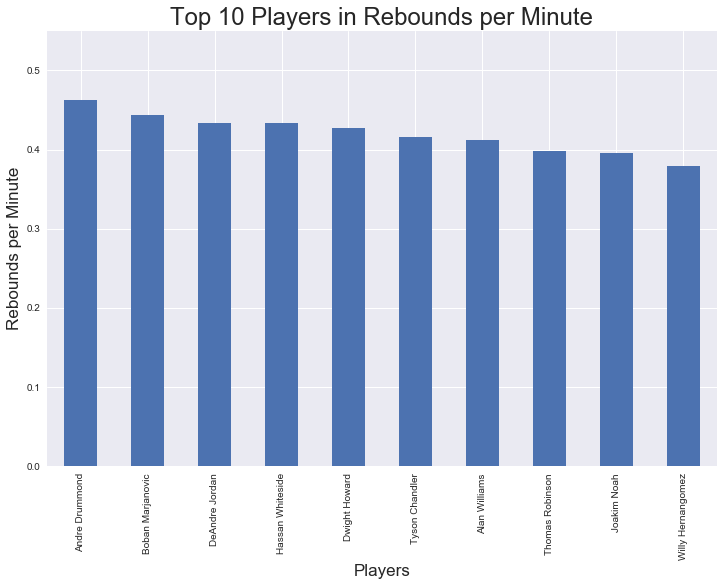

In [85]:
fig,ax = plt.subplots()
Top10TRBperMin.plot.bar(x='Player',y='TRBperMP',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,0.55)
ax.set_title('Top 10 Players in Rebounds per Minute',size=24)
ax.set_ylabel('Rebounds per Minute',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Rebounds per Minute

In [86]:
stats17['TRBperMP'] = stats17['TRB']/stats17['MP']
TRBperMin2= (stats17.loc[stats17['MP'] > 164][stats17['Salary'] < stats17['Salary'].median()]
             [['Player','Pos','Age','PTS','MP','TRBperMP','Salary']])
Top10TRBperMin2 = TRBperMin2.sort_values('TRBperMP', ascending = False).head(10)
Top10TRBperMin2
# We filtered our data to only include players with more than 2 minutes played per game in order for the most accurate results.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,PTS,MP,TRBperMP,Salary
642,Alan Williams,C,24.0,346.0,708.0,0.412429,874636
513,Thomas Robinson,PF,25.0,241.0,560.0,0.398214,1050961
272,Willy Hernangomez,C,22.0,587.0,1324.0,0.379154,1375000
226,Rudy Gobert,C,24.0,1137.0,2744.0,0.377187,2121288
152,Dewayne Dedmon,C,27.0,387.0,1330.0,0.372180,2898000
158,Cheick Diallo,PF,20.0,87.0,199.0,0.366834,543471
380,Shawn Long,C,24.0,148.0,234.0,0.363248,96969
333,Nikola Jokic,C,21.0,1221.0,2038.0,0.352306,1358500
413,Salah Mejri,C,30.0,213.0,905.0,0.340331,874636
106,Clint Capela,C,22.0,818.0,1551.0,0.339136,1296240


**NOTES:** This chart shows very high value players, as they are able to put up impressive numbers while all costing less than $3 million and most of which are younger than 25 years old. Teams should target these players to boost their rebounding numbers without spending much money and creating a long term value with young players.

Text(0.5, 0, 'Players')

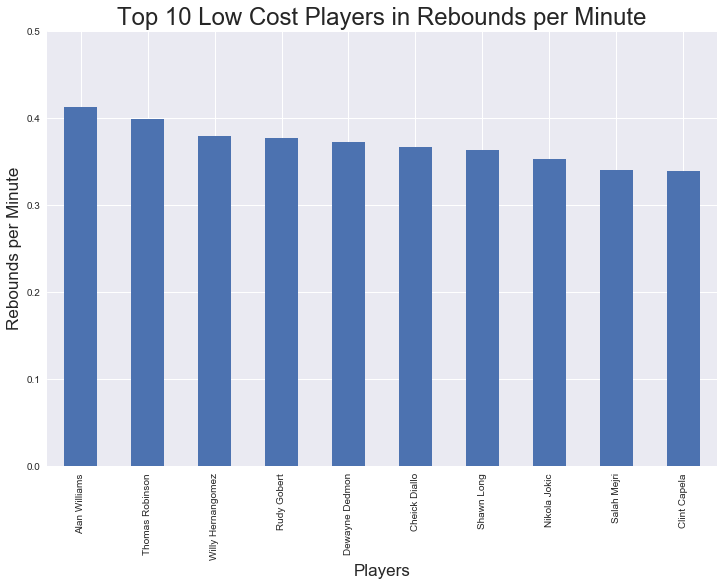

In [87]:
fig,ax = plt.subplots()
Top10TRBperMin2.plot.bar(x='Player',y='TRBperMP',ax=ax,figsize=(12,8),legend = False)
ax.set_ylim(0,0.5)
ax.set_title('Top 10 Low Cost Players in Rebounds per Minute',size=24)
ax.set_ylabel('Rebounds per Minute',size = 17)
ax.set_xlabel('Players',size = 17)

### Usage %

#### Low Minutes, High USG%

In [88]:
LowMinHiUSG = (stats17.loc[stats17['MP'] < stats17['MP'].median()][stats17['MP'] > 164]
               [stats17['USG%'] > stats17['USG%'].median()][['Player','Pos','Age','Tm','USG%','MP','Salary']])
#Adjusted for players who barely played and saw high usage rate as a result
Top10LowMinHiUSG = LowMinHiUSG.sort_values('USG%', ascending = False).head(10)
Top10LowMinHiUSG

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Tm,USG%,MP,Salary
177,Joel Embiid,C,22.0,PHI,36.0,786.0,4826160
182,Tyreke Evans,SF,27.0,TOT,26.7,788.0,10661286
378,Jeremy Lin,PG,28.0,BRK,26.6,883.0,11483254
221,Jonathan Gibson,PG,29.0,DAL,26.3,231.0,680937
33,J.J. Barea,PG,32.0,DAL,26.2,771.0,4096950
316,Al Jefferson,C,32.0,IND,26.1,931.0,10230179
213,Rudy Gay,SF,30.0,SAC,25.8,1013.0,13333333
143,Jordan Crawford,SG,28.0,NOP,25.5,442.0,234915
380,Shawn Long,C,24.0,PHI,25.4,234.0,96969
49,Michael Beasley,PF,28.0,MIL,25.3,935.0,1403611


**NOTES:** This chart shows the players who played fewer minutes than 50% of the league who were used the most by their respective teams while on the court, suggesting that they may deserve more minutes. Some key players on here are Joel Embiid and Shawn Long, as they produced these numbers while being under age 25. Additionally, Shawn Long, Jordan Crawford, and Jonathan Gibson are all under $1,000,000, showing that they give a high return on investment on their salaries for their teams.

Text(0.5, 0, 'Players')

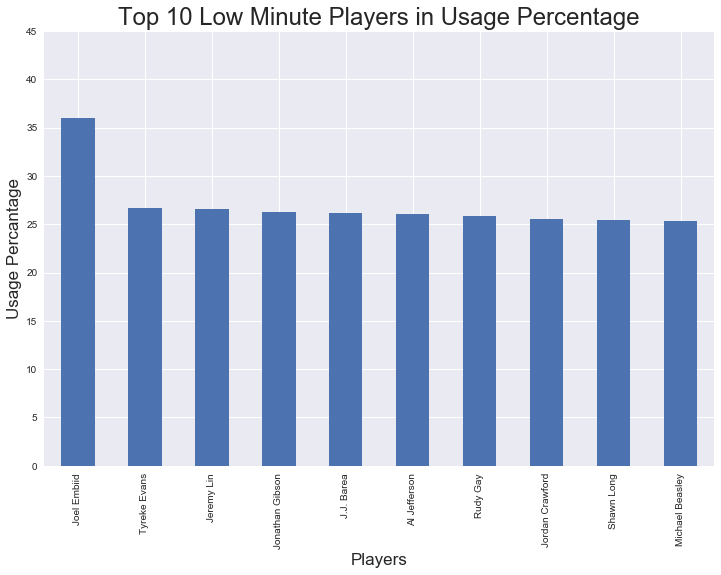

In [89]:
fig,ax = plt.subplots()
Top10LowMinHiUSG.plot.bar(x='Player',y='USG%',ax=ax,figsize=(12,8),legend=False)
ax.set_ylim(0,45)
ax.set_title('Top 10 Low Minute Players in Usage Percentage',size=24)
ax.set_ylabel('Usage Percantage',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High Usage

In [90]:
LowSALHiUSG = (stats17.loc[stats17['Salary'] < stats17['Salary'].median()][stats17['MP'] > 164]
               [['Player','Pos','Age','USG%','Salary']])
Top10LowSALHiUSG = LowSALHiUSG.sort_values('USG%', ascending = False).head(10)
Top10LowSALHiUSG

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Player,Pos,Age,USG%,Salary
73,Devin Booker,SG,20.0,28.6,2223600
22,Giannis Antetokounmpo,SF,22.0,28.3,2995421
529,Dennis Schroder,PG,23.0,27.8,2708582
396,C.J. McCollum,SG,25.0,27.5,3219579
620,Dion Waiters,SG,25.0,26.3,2898000
221,Jonathan Gibson,PG,29.0,26.3,680937
143,Jordan Crawford,SG,28.0,25.5,234915
380,Shawn Long,C,24.0,25.4,96969
49,Michael Beasley,PF,28.0,25.3,1403611
527,Dario Saric,PF,22.0,24.6,2318280


**NOTES:** This chart shows the usage percentages for players below the median salary. Devon Booker and Giannis Antetokuonmpo are extremely valuable, as they are 20 and 22 respectively and have usage rates above 28%.

Text(0.5, 0, 'Players')

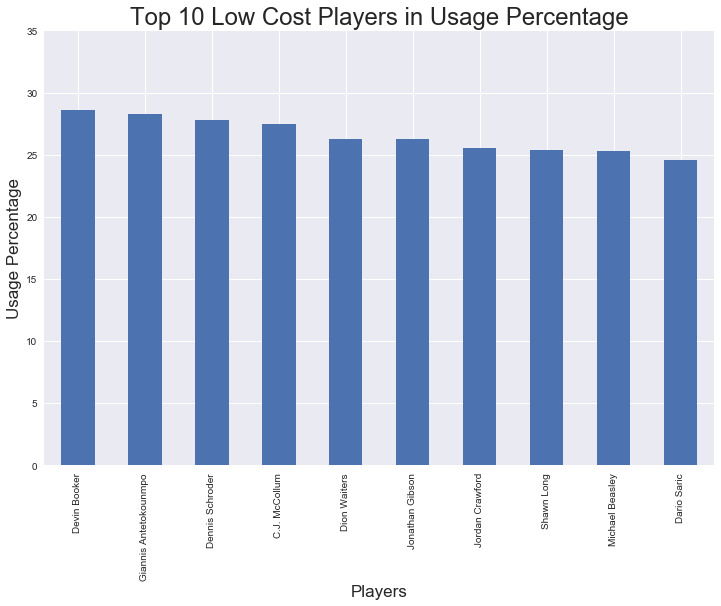

In [91]:
fig,ax = plt.subplots()
Top10LowSALHiUSG.plot.bar(x='Player',y='USG%',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,35)
ax.set_title('Top 10 Low Cost Players in Usage Percentage',size=24)
ax.set_ylabel('Usage Percentage',size = 17)
ax.set_xlabel('Players',size = 17)

### PER

#### Low Minutes, High PER

In [92]:
LowMinHiPER = (stats17.loc[stats17['MP'] < stats17['MP'].median()][stats17['MP'] > 164]
               [stats17['PER'] > stats17['PER'].median()][['Player','Pos','Age','Tm','PER','MP','Salary']])
#Adjusted for players who barely played and saw high PER as a result
Top10LowMinHiPER = LowMinHiPER.sort_values('PER', ascending = False).head(10)
Top10LowMinHiPER

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Tm,PER,MP,Salary
391,Boban Marjanovic,C,28.0,DET,29.6,293.0,7000000
407,JaVale McGee,C,29.0,GSW,25.2,739.0,1403611
380,Shawn Long,C,24.0,PHI,24.1,234.0,96969
177,Joel Embiid,C,22.0,PHI,24.1,786.0,4826160
446,Nerlens Noel,C,22.0,TOT,20.4,1047.0,4384490
42,Brandon Bass,PF,31.0,LAC,19.7,577.0,1551659
642,Alan Williams,C,24.0,PHO,19.5,708.0,874636
256,Montrezl Harrell,C,23.0,HOU,19.2,1064.0,1045000
378,Jeremy Lin,PG,28.0,BRK,19.2,883.0,11483254
316,Al Jefferson,C,32.0,IND,18.9,931.0,10230179


**NOTES:** This chart shows players who played less than the median amount of minutes but provided a high PER during their time on the court. Shawn Long, Alan Williams, and Montrezl Harrell are all highly valuable players, as they provide high efficiency ratings while costing less than $1.5 million and under 25 years old.

Text(0.5, 0, 'Players')

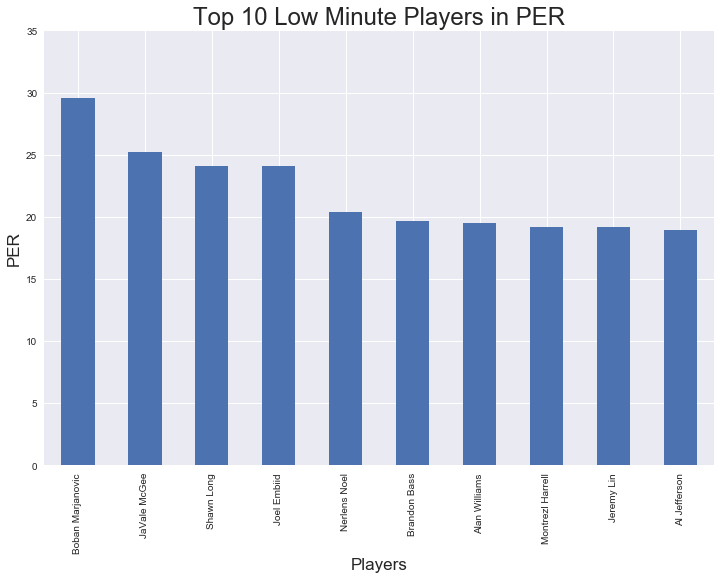

In [93]:
fig,ax = plt.subplots()
Top10LowMinHiPER.plot.bar(x='Player',y='PER',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,35)
ax.set_title('Top 10 Low Minute Players in PER',size=24)
ax.set_ylabel('PER',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High PER

In [94]:
LowSALHiPER = (stats17.loc[stats17['Salary'] < stats17['Salary'].median()][stats17['MP'] > 164]
               [stats17['PER'] > stats17['PER'].median()][['Player','Pos','Age','Tm','PER','MP','Salary']])
#Adjusted for players who barely played and saw high PER as a result
Top10LowSALHiPER = LowSALHiPER.sort_values('PER', ascending = False).head(10)
Top10LowSALHiPER

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Tm,PER,MP,Salary
333,Nikola Jokic,C,21.0,DEN,26.4,2038.0,1358500
22,Giannis Antetokounmpo,SF,22.0,MIL,26.1,2845.0,2995421
407,JaVale McGee,C,29.0,GSW,25.2,739.0,1403611
380,Shawn Long,C,24.0,PHI,24.1,234.0,96969
226,Rudy Gobert,C,24.0,UTA,23.3,2744.0,2121288
106,Clint Capela,C,22.0,HOU,21.4,1551.0,1296240
396,C.J. McCollum,SG,25.0,POR,19.9,2796.0,3219579
42,Brandon Bass,PF,31.0,LAC,19.7,577.0,1551659
642,Alan Williams,C,24.0,PHO,19.5,708.0,874636
256,Montrezl Harrell,C,23.0,HOU,19.2,1064.0,1045000


**NOTES:** This chart shows the players who are inexpensive, but offer a very high PER. The players on this chart are low cost and tend to be young, adding value to a team.

Text(0.5, 0, 'Players')

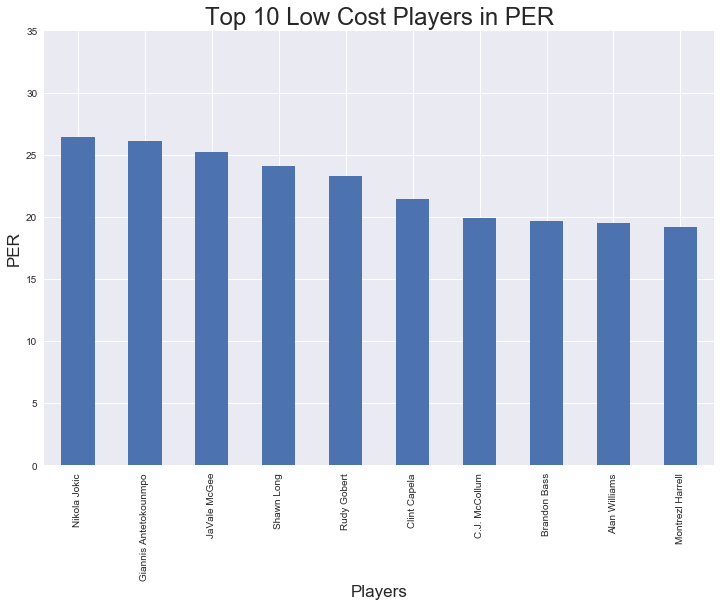

In [95]:
fig,ax = plt.subplots()
Top10LowSALHiPER.plot.bar(x='Player',y='PER',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,35)
ax.set_title('Top 10 Low Cost Players in PER',size=24)
ax.set_ylabel('PER',size = 17)
ax.set_xlabel('Players',size = 17)

### BPM

#### Low Minutes, High BPM

In [96]:
LowMinHiBPM = (stats17.loc[stats17['MP'] < stats17['MP'].median()][stats17['MP'] > 164]
               [stats17['BPM'] > stats17['BPM'].median()][['Player','Pos','Age','Tm','BPM','MP','Salary']])
#Adjusted for players who barely played and saw high BPM as a result of lack of minutes
Top10LowMinHiBPM = LowMinHiBPM.sort_values('BPM', ascending = False).head(10)
Top10LowMinHiBPM

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Tm,BPM,MP,Salary
449,Lucas Nogueira,C,24.0,TOR,5.4,1088.0,1921320
380,Shawn Long,C,24.0,PHI,3.4,234.0,96969
446,Nerlens Noel,C,22.0,TOT,3.3,1047.0,4384490
177,Joel Embiid,C,22.0,PHI,3.2,786.0,4826160
635,David West,C,36.0,GSW,2.2,854.0,1551659
445,Joakim Noah,C,31.0,NYK,2.1,1015.0,17000000
378,Jeremy Lin,PG,28.0,BRK,2.0,883.0,11483254
57,Davis Bertans,PF,24.0,SAS,1.7,808.0,543471
288,Richaun Holmes,C,23.0,PHI,1.7,1193.0,1025831
20,Kyle Anderson,SG,23.0,SAS,1.6,1020.0,1192080


**NOTES:** Despite low minutes played, Lucas Noguiera, Shawn Long, Nerlens Noel, and Joel Embiid all posted high BPMs, and being under 25 years old, they offer very high value to their teams.

Text(0.5, 0, 'Players')

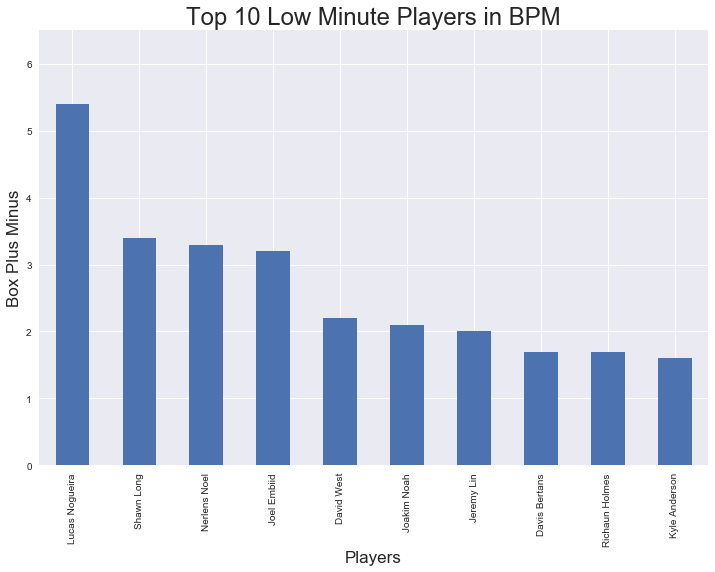

In [97]:
fig,ax = plt.subplots()
Top10LowMinHiBPM.plot.bar(x='Player',y='BPM',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,6.5)
ax.set_title('Top 10 Low Minute Players in BPM',size=24)
ax.set_ylabel('Box Plus Minus',size = 17)
ax.set_xlabel('Players',size = 17)

#### Low Salary, High BPM

In [98]:
LowSALHiBPM = (stats17.loc[stats17['Salary'] < stats17['Salary'].median()][stats17['MP'] > 164]
               [stats17['BPM'] > stats17['BPM'].median()][['Player','Pos','Age','Tm','BPM','MP','Salary']])
#Adjusted for players who barely played and saw high BPM as a result of lack of minutes
Top10LowSALHiBPM = LowSALHiBPM.sort_values('BPM', ascending = False).head(10)
Top10LowSALHiBPM

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Tm,BPM,MP,Salary
333,Nikola Jokic,C,21.0,DEN,8.3,2038.0,1358500
22,Giannis Antetokounmpo,SF,22.0,MIL,7.6,2845.0,2995421
226,Rudy Gobert,C,24.0,UTA,5.8,2744.0,2121288
449,Lucas Nogueira,C,24.0,TOR,5.4,1088.0,1921320
380,Shawn Long,C,24.0,PHI,3.4,234.0,96969
368,David Lee,PF,33.0,SAS,3.2,1477.0,1551659
463,Zaza Pachulia,C,32.0,GSW,2.7,1268.0,2898000
306,Joe Ingles,SF,29.0,UTA,2.7,1972.0,2250000
481,Mason Plumlee,C,26.0,TOT,2.6,2148.0,2328530
604,Myles Turner,C,20.0,IND,2.4,2541.0,2463840


**NOTES:** This chart shows low cost players with the highest BPMs. Nikola Jokic and Giannis Antetokuonmpo posted extremely high numbers, and provide very high value to teams given their young age and low salaries.

Text(0.5, 0, 'Players')

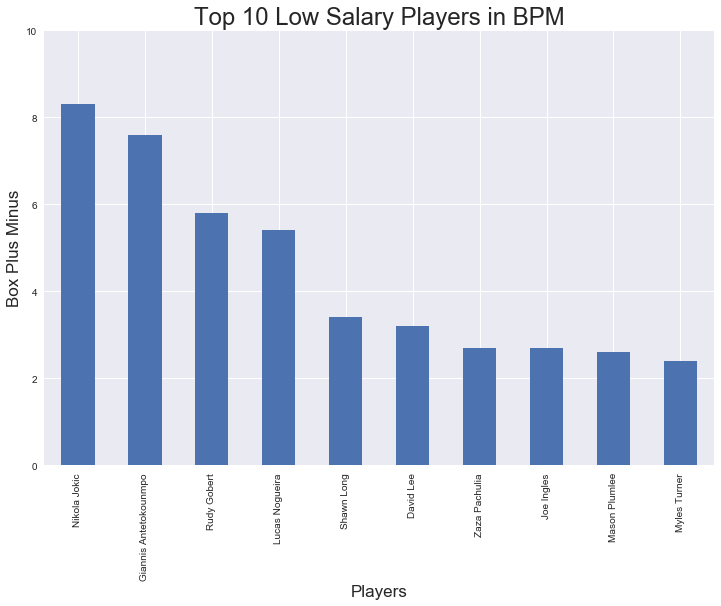

In [99]:
fig,ax = plt.subplots()
Top10LowSALHiBPM.plot.bar(x='Player',y='BPM',ax=ax,figsize=(12,8), legend = False)
ax.set_ylim(0,10)
ax.set_title('Top 10 Low Salary Players in BPM',size=24)
ax.set_ylabel('Box Plus Minus',size = 17)
ax.set_xlabel('Players',size = 17)

## Model for Valuation of Players
    Based off the correlation coefficients to win share, we weighted different statistics to determine the most 
    valuable players. We then compared our model with previous years to assess its accuracy, and further compared 
    player values given salaries and positions.

In [100]:
stats17['Value'] = ((stats17['BPM']*.8645+stats17['PER']*.5245+stats17['USG%']*.2532+stats17['PTS']*.0052+
                    stats17['AST']*.0104+stats17['TRB']*.0103+stats17['STL']*.0583+stats17['BLK']*.0452)/8)

In [115]:
statsVal = stats17.sort_values('Value', ascending = False).reset_index(drop = True)
statsVal[['Player','Pos','Age','Salary','Value']].head(20)

,Player,Pos,Age,Salary,Value
0,Russell Westbrook,PG,28.0,26540100,10.023280
1,James Harden,PG,27.0,26540100,8.604930
2,Giannis Antetokounmpo,SF,22.0,2995421,7.892214
3,Anthony Davis,C,23.0,22116750,7.572340
4,DeMarcus Cousins,C,26.0,16957900,7.521981
5,LeBron James,SF,32.0,30963450,7.480362
6,Karl-Anthony Towns,C,21.0,5960160,7.034812
7,Kawhi Leonard,SF,25.0,17638063,7.032502
8,John Wall,PG,26.0,16957900,7.016052
9,Stephen Curry,PG,28.0,12112359,6.926259


**NOTES:** We believe our valuation model is very accurate, as our number 1 player was the league MVP, and 11 of the top 12 players were on the All-Star Team. Karl-Anthony Towns was the exception, and he was considered an all star snub and has made the all star team every year since. Additionally, the 13th and 14th players (Rudy Gobert and Nikola Jokic), who were not selected for the All-Star Team, were selected for the All-Star game in the following years. Therefore, we believe our model helps determine a players value while simultaneously showing underrated players who are on the rise.

In [102]:
stats['Value'] = ((stats['BPM']*.8645+stats['PER']*.5245+stats['USG%']*.2532+stats['PTS']*.0052+
                    stats['AST']*.0104+stats['TRB']*.0103+stats['STL']*.0583+stats['BLK']*.0452)/8)

In [117]:
statsVal2 = stats.sort_values('Value', ascending = False)
statsVal2.loc[statsVal2['Year'] == 2016].head(20)

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Value
23633,2016.0,Stephen Curry,PG,27.0,GSW,79.0,79.0,2700.0,31.5,0.669,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,805.0,1598.0,0.504,402.0,886.0,0.454,403.0,712.0,0.566,0.630,363.0,400.0,0.908,68.0,362.0,430.0,527.0,169.0,15.0,262.0,161.0,2375.0,8.546603
24070,2016.0,Russell Westbrook,PG,27.0,OKC,80.0,80.0,2750.0,27.6,0.554,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,656.0,1444.0,0.454,101.0,341.0,0.296,555.0,1103.0,0.503,0.489,465.0,573.0,0.812,145.0,481.0,626.0,834.0,163.0,20.0,342.0,200.0,1878.0,8.302027
23722,2016.0,James Harden,SG,26.0,HOU,82.0,82.0,3125.0,25.3,0.598,0.406,0.518,2.2,15.6,8.8,35.4,2.2,1.4,15.9,32.5,10.7,2.6,13.3,0.204,7.1,-0.4,6.7,6.9,710.0,1617.0,0.439,236.0,657.0,0.359,474.0,960.0,0.494,0.512,720.0,837.0,0.860,63.0,438.0,501.0,612.0,139.0,51.0,374.0,229.0,2376.0,7.697525
23781,2016.0,LeBron James,SF,31.0,CLE,76.0,76.0,2709.0,27.5,0.588,0.199,0.347,4.7,18.8,11.8,36.0,2.0,1.5,13.2,31.4,9.6,4.0,13.6,0.242,6.9,2.3,9.1,7.6,737.0,1416.0,0.520,87.0,282.0,0.309,650.0,1134.0,0.573,0.551,359.0,491.0,0.731,111.0,454.0,565.0,514.0,104.0,49.0,249.0,143.0,1920.0,7.458535
23654,2016.0,Kevin Durant,SF,27.0,OKC,72.0,72.0,2578.0,28.2,0.634,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,698.0,1381.0,0.505,186.0,481.0,0.387,512.0,900.0,0.569,0.573,447.0,498.0,0.898,45.0,544.0,589.0,361.0,69.0,85.0,250.0,137.0,2029.0,7.200621
23938,2016.0,Chris Paul,PG,30.0,LAC,74.0,74.0,2420.0,26.2,0.575,0.295,0.294,1.8,12.0,7.0,52.7,3.1,0.4,13.4,27.1,9.2,3.5,12.7,0.253,7.3,0.5,7.8,6.0,515.0,1114.0,0.462,122.0,329.0,0.371,393.0,785.0,0.501,0.517,294.0,328.0,0.896,39.0,271.0,310.0,738.0,152.0,13.0,194.0,185.0,1446.0,6.897915
23892,2016.0,Paul Millsap,PF,30.0,ATL,81.0,81.0,2647.0,21.3,0.556,0.218,0.383,8.4,21.5,15.1,16.4,2.7,4.1,13.3,24.3,4.1,6.0,10.1,0.183,1.1,4.2,5.3,4.9,501.0,1066.0,0.470,74.0,232.0,0.319,427.0,834.0,0.512,0.505,309.0,408.0,0.757,198.0,534.0,732.0,265.0,147.0,139.0,191.0,237.0,1385.0,6.782120
23839,2016.0,Kawhi Leonard,SF,24.0,SAS,72.0,72.0,2380.0,26.0,0.616,0.267,0.306,4.7,18.4,11.8,13.0,2.8,2.3,7.8,25.8,8.3,5.5,13.7,0.277,5.5,2.8,8.3,6.2,551.0,1090.0,0.506,129.0,291.0,0.443,422.0,799.0,0.528,0.565,292.0,334.0,0.874,95.0,398.0,493.0,186.0,128.0,71.0,105.0,133.0,1523.0,6.618551
23623,2016.0,DeMarcus Cousins,C,25.0,SAC,65.0,65.0,2246.0,23.6,0.538,0.158,0.498,7.7,28.2,18.0,17.0,2.2,3.3,13.3,35.4,2.4,3.3,5.7,0.122,1.0,1.6,2.6,2.6,601.0,1332.0,0.451,70.0,210.0,0.333,531.0,1122.0,0.473,0.477,476.0,663.0,0.718,158.0,589.0,747.0,214.0,101.0,92.0,249.0,236.0,1748.0,6.580647
23849,2016.0,Kyle Lowry,PG,29.0,TOR,77.0,77.0,2851.0,22.2,0.578,0.457,0.410,2.2,12.3,7.3,29.9,2.9,1.0,13.7,26.1,8.0,3.7,11.6,0.196,6.2,0.6,6.8,6.3,512.0,1198.0,0.427,212.0,547.0,0.388,300.0,651.0,0.461,0.516,398.0,491.0,0.811,55.0,310.0,365.0,494.0,158.0,34.0,225.0,211.0,1634.0,6.534140


**NOTES:** Each of the top 13 rated players were on the 2016 all-star team, with our highest valued player, Stephen Curry, winning league Most Valuable Player in 2016. Therefore, this further supports the accuracy of our model.

## Top Players By Position: 
    This section is designed for an easy view of top players by position for GMs to review and use in making transactional decisions. It also looks into low cost players with high value at each position.

### Point Guard

#### Top 10 PG

In [114]:
statsVal.loc[statsVal['Pos'] == 'PG'][['Player','Pos','Age','Salary','Value']].head(10)

,Player,Pos,Age,Salary,Value
0,Russell Westbrook,PG,28.0,26540100,10.023280
1,James Harden,PG,27.0,26540100,8.604930
8,John Wall,PG,26.0,16957900,7.016052
9,Stephen Curry,PG,28.0,12112359,6.926259
14,Isaiah Thomas,PG,27.0,6587132,6.268412
15,Chris Paul,PG,31.0,22868827,6.176166
16,Damian Lillard,PG,26.0,24328425,6.010350
23,Kemba Walker,PG,26.0,12000000,5.604974
25,Mike Conley,PG,29.0,26540100,5.552233
26,Kyle Lowry,PG,30.0,12000000,5.548635


**NOTES:** As the only top 10 PG with a salary under $10 million, it is very possible that Isaiah Thomas is undervalued, and GMs should look into signing him if possible.

#### Top 10 Low Cost PG

In [118]:
(statsVal.loc[statsVal['Pos'] == 'PG'][statsVal['Salary'] < statsVal['Salary'].median()]
 [statsVal['MP'] > 164][['Player','Pos','Age','Salary','Value']].head(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Salary,Value
44,Elfrid Payton,PG,22.0,2613600,4.641734
58,Dennis Schroder,PG,23.0,2708582,4.376557
99,T.J. McConnell,PG,24.0,874636,3.560435
109,Seth Curry,PG,26.0,2898000,3.457219
147,Ty Lawson,PG,29.0,1315448,3.168144
198,Raymond Felton,PG,32.0,1551659,2.629550
214,Tim Frazier,PG,26.0,2090000,2.492970
221,Yogi Ferrell,PG,23.0,239767,2.427303
228,Spencer Dinwiddie,PG,23.0,726672,2.364702
242,Jerian Grant,PG,24.0,1643040,2.259975


**NOTES:** As the third best low cost PG, TJ McConnell deserves a closer look by GMs, as he is priced very low (under 1 million dollars) and is only 24 years old. GMs should also consider Elfrid Payton, as he is highly valued at the age of 22 and a salary less than $3 million.

### Shooting Guard

#### Top 10 SG

In [119]:
statsVal.loc[statsVal['Pos'] == 'SG'][['Player','Pos','Age','Salary','Value']].head(10)

,Player,Pos,Age,Salary,Value
24,DeMar DeRozan,SG,27.0,26540100,5.585201
38,C.J. McCollum,SG,25.0,3219579,4.984344
39,Bradley Beal,SG,23.0,22116750,4.928944
46,Nicolas Batum,SG,28.0,20869566,4.629320
49,Lou Williams,SG,30.0,7000000,4.595277
55,Dwyane Wade,SG,35.0,23200000,4.475196
56,Klay Thompson,SG,26.0,16663575,4.413484
71,Devin Booker,SG,20.0,2223600,4.048096
77,Marcus Smart,SG,22.0,3578880,3.862314
87,Patrick Beverley,SG,28.0,6000000,3.697759


**NOTES:** Our model's accuracy is further supported by this chart, as each of these players could be considered an elite player in the NBA. GMs should heavily target Devin Booker, a 20 year old stud who's salary costs less than $2.5 million

#### Top 10 Low Cost SG

In [120]:
(statsVal.loc[statsVal['Pos'] == 'SG'][statsVal['Salary'] < statsVal['Salary'].median()]
 [statsVal['MP'] > 164][['Player','Pos','Age','Salary','Value']].head(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Salary,Value
38,C.J. McCollum,SG,25.0,3219579,4.984344
71,Devin Booker,SG,20.0,2223600,4.048096
113,Tim Hardaway,SG,24.0,2281605,3.429769
119,Gary Harris,SG,22.0,1655880,3.384372
120,Malcolm Brogdon,SG,24.0,925000,3.373213
156,Dion Waiters,SG,25.0,2898000,3.040514
165,Zach LaVine,SG,21.0,2240880,2.930149
174,Sean Kilpatrick,SG,27.0,980431,2.822191
186,Justin Holiday,SG,27.0,1015696,2.728635
187,Jamal Murray,SG,19.0,3210840,2.721096


**NOTES:** Each of these players are extremely valuable, as most are very young, and all are rated excellently. However, once again, Devin Booker is arguably the best pick on this chart. At 20 years old and performing at such a high level for a low cost, it is without question that he should be targeted.

### Small Forward

#### Top 10 SF

In [121]:
statsVal.loc[statsVal['Pos'] == 'SF'][['Player','Pos','Age','Salary','Value']].head(10)

,Player,Pos,Age,Salary,Value
2,Giannis Antetokounmpo,SF,22.0,2995421,7.892214
5,LeBron James,SF,32.0,30963450,7.480362
7,Kawhi Leonard,SF,25.0,17638063,7.032502
10,Jimmy Butler,SF,27.0,17552209,6.780512
11,Kevin Durant,SF,28.0,26540100,6.655458
21,Paul George,SF,26.0,18314532,5.660310
28,Gordon Hayward,SF,26.0,16073140,5.302115
45,Otto Porter,SF,23.0,5893981,4.629703
51,Carmelo Anthony,SF,32.0,24559380,4.564890
57,Andrew Wiggins,SF,21.0,6006600,4.400675


**NOTES:** Not only is Giannis Antetokounmpo the highest ranked SF and 3rd ranked overall player at just the age of 22, but he also has a salary that is under $3 million. It is a no brainer that all GMs should target this player heavily, but it will be hard to take him away from his team without trading a lot away.

#### Top 10 Low Cost SF

In [122]:
(statsVal.loc[statsVal['Pos'] == 'SF'][statsVal['Salary'] < statsVal['Salary'].median()]
 [statsVal['MP'] > 164][['Player','Pos','Age','Salary','Value']].head(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Salary,Value
2,Giannis Antetokounmpo,SF,22.0,2995421,7.892214
63,Robert Covington,SF,26.0,1015696,4.195305
102,T.J. Warren,SF,23.0,2128920,3.524349
110,Rondae Hollis-Jefferson,SF,22.0,1395600,3.449074
131,Joe Ingles,SF,29.0,2250000,3.293079
157,Andre Roberson,SF,25.0,2183072,3.040015
205,Justin Anderson,SF,23.0,1514160,2.575679
224,Sam Dekker,SF,22.0,1720560,2.392654
235,Caris LeVert,SF,22.0,1562280,2.297921
243,James Ennis,SF,26.0,2898000,2.244500


**NOTES:** Besides Giannis Antetokounmpo, Rondae Hollis-Jefferson is a player that should be heavily targeted by GMs. At 22 years old and a cost of just $1.4 million, he provides long term rewards for a low cost, and is already performing at a very high level according to his valuation.

### Power Forward

#### Top 10 PF

In [123]:
statsVal.loc[statsVal['Pos'] == 'PF'][['Player','Pos','Age','Salary','Value']].head(10)

,Player,Pos,Age,Salary,Value
17,Draymond Green,PF,26.0,15330435,5.867736
30,Blake Griffin,PF,27.0,20140838,5.286569
36,Paul Millsap,PF,31.0,20072033,5.060954
47,James Johnson,PF,29.0,4000000,4.617744
48,LaMarcus Aldridge,PF,31.0,20575005,4.615131
50,Kevin Love,PF,28.0,21165675,4.566491
53,Kristaps Porzingis,PF,21.0,4317720,4.523570
60,Gorgui Dieng,PF,27.0,2348783,4.304656
61,Serge Ibaka,PF,27.0,12250000,4.245497
65,Tobias Harris,PF,24.0,17200000,4.160936


**NOTES:** At 21 years old, 5th best PF, and under $5 million, any GM would desire Kristaps Porzingis and his shooting and blocking abilities for his team.

#### Top 10 Low Cost PF

In [124]:
(statsVal.loc[statsVal['Pos'] == 'PF'][statsVal['Salary'] < statsVal['Salary'].median()]
 [statsVal['MP'] > 164][['Player','Pos','Age','Salary','Value']].head(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Salary,Value
60,Gorgui Dieng,PF,27.0,2348783,4.304656
92,David Lee,PF,33.0,1551659,3.641047
100,Dario Saric,PF,22.0,2318280,3.538028
144,JaMychal Green,PF,26.0,980431,3.190466
149,Marquese Chriss,PF,19.0,2941440,3.156286
159,Terrence Jones,PF,25.0,1050961,3.027154
193,Michael Beasley,PF,28.0,1403611,2.671564
225,Brandon Bass,PF,31.0,1551659,2.386805
241,Thomas Robinson,PF,25.0,1050961,2.265230
245,Davis Bertans,PF,24.0,543471,2.214530


**NOTES:** Dario Saric, 22 years old, $2.3 million salary and high value, along with Marquese Chriss, an already high valued PF at just 19 years old, provide immense potential return both short and long term for a team, while still being low cost. Therefore, GMs should look into adding these players.

### Center

#### Top 10 C

In [125]:
statsVal.loc[statsVal['Pos'] == 'C'][['Player','Pos','Age','Salary','Value']].head(10)

,Player,Pos,Age,Salary,Value
3,Anthony Davis,C,23.0,22116750,7.572340
4,DeMarcus Cousins,C,26.0,16957900,7.521981
6,Karl-Anthony Towns,C,21.0,5960160,7.034812
12,Rudy Gobert,C,24.0,2121288,6.446824
13,Nikola Jokic,C,21.0,1358500,6.317256
18,Andre Drummond,C,23.0,22116750,5.842966
19,Hassan Whiteside,C,27.0,22116750,5.789636
20,DeAndre Jordan,C,28.0,21165675,5.715382
22,Marc Gasol,C,32.0,21165675,5.635523
31,Myles Turner,C,20.0,2463840,5.262169


**NOTES:** Rudy Gobert and Nikola Jokic, 13th and 14th overall and 4th and 5th ranked centers, provide very high returns for their teams for a low cost, and offer to continue doing this long term as they age. Therefore, they are very attractive players to Gms.

#### Top 10 Low Cost C

In [126]:
(statsVal.loc[statsVal['Pos'] == 'C'][statsVal['Salary'] < statsVal['Salary'].median()]
 [statsVal['MP'] > 164][['Player','Pos','Age','Salary','Value']].head(10))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Player,Pos,Age,Salary,Value
12,Rudy Gobert,C,24.0,2121288,6.446824
13,Nikola Jokic,C,21.0,1358500,6.317256
31,Myles Turner,C,20.0,2463840,5.262169
41,Mason Plumlee,C,26.0,2328530,4.759871
62,Steven Adams,C,23.0,3140517,4.222405
66,Clint Capela,C,22.0,1296240,4.132835
78,Jusuf Nurkic,C,22.0,1921320,3.856104
91,JaVale McGee,C,29.0,1403611,3.651958
101,Willy Hernangomez,C,22.0,1375000,3.536489
111,Richaun Holmes,C,23.0,1025831,3.447846


**NOTES:** Besides Rudy Gobert and Nikola Jokic, Myles Turner offers a high return to his team and should be targeted by GMs., as he is just 20 years old, $2.5 million, and the 32nd ranked overal player, 10th best center in the NBA. Jusuf Nurkic and Clint Capela are also attractive prospects, as they are low cost, 22 years old, and already performing at a high level.